# LLMs Evolutionary-Merging for L2S Reasoning

## 🛠️ Environment Setup 


### ⚠️ Before running the library, you need to configure a Python virtual environment.
> Requirement: Python 3.11 is required to ensure full compatibility with all Mergenetic dependencies \
> Important: Use provided  ~/mergenetic (do NOT clone mergenetic repository again) \
> Important: Use provided  ~/Qwen2.5-Math (do NOT clone Qwen2.5-Math repository again) 

### 🐍 Create and activate the virtual environment
```bash
python3.11 -m venv ~/mergenetic/.venv
source ~/mergenetic/.venv/bin/activate
```
### 📦 Install all required dependencies 
Install basic packages for notebooks:
```bash
pip install jupyter ipykernel
pip install --upgrade pip
```
Dependencies for Mergenetic framework
```bash
cd mergenetic
pip install -r requirements.txt
pip install -e .
```
Dependencies for Qwen2.5-Math evaluation framework
```bash
cd ../Qwen2.5-Math/evaluation
pip install -r requirements.txt
cd latex2sympy  
pip install -e . 
```
Register the venv as a Jupyter kernel so it can be selected in notebooks or VS Code
```bash
python -m ipykernel install --user --name=mergenetic --display-name "Python (mergenetic)"
```



In [1]:
%cd mergenetic

/Users/iacobelli/Downloads/DLAI-project/mergenetic


In [2]:
# ==== Imports ====
import os, random, numpy as np, torch

# pymoo components
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from mergenetic.merging.taskarithmetic_merger import TaskArithmeticMerger
from mergenetic.merging.ties_merger import TiesMerger
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Mergekit and Mergenetic
import mergekit
import mergenetic
from mergenetic.searcher import Searcher
from mergenetic.utils import ConfigLmEval
from mergenetic import PROJECT_ROOT
from mergenetic.optimization.predefined_problems import (MathReasoningProblem, ConfigPE) 

# lm_eval
from lm_eval.tasks import TaskManager

# Hugging Face 
from huggingface_hub import whoami
from huggingface_hub import notebook_login
from huggingface_hub import snapshot_download



PROJECT_ROOT IS HARCODED AT /Users/iacobelli/Downloads/DLAI-project


In [3]:
import sys, importlib, pathlib

# 0) make sure the real code exists
real_pkg_dir = pathlib.Path(f"{PROJECT_ROOT}/mergenetic/src/mergenetic")
if not real_pkg_dir.exists():
    raise RuntimeError("mergenetic/src/mergenetic not found – is the repo cloned?")

# 1) purge every cached mergenetic module
for name in list(sys.modules):
    if name == "mergenetic" or name.startswith("mergenetic."):
        del sys.modules[name]

# 2) put src/ directory *first* on sys.path
src_root = str(real_pkg_dir.parent)  # /mergenetic/src
if src_root not in sys.path:
    sys.path.insert(0, src_root)

# 3) also remove /content from sys.path if present
for bad in ("", "/content"):
    if bad in sys.path:
        sys.path.remove(bad)

# 4) reload
importlib.invalidate_caches()
import mergenetic, inspect, textwrap

print("Now using:", inspect.getfile(mergenetic))
print("Public names:", textwrap.shorten(", ".join(dir(mergenetic)), 100))

Now using: /Users/iacobelli/Downloads/DLAI-project/mergenetic/src/mergenetic/__init__.py
Public names: Any, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, CACHE_DIR, Config, ConfigLmEval, [...]


In [4]:
# ==== Set the seeds ====
SEED = 42

# Python
random.seed(SEED)
# NumPy
np.random.seed(SEED)
# PyTorch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Environment variables
os.environ["PYTHONHASHSEED"] = str(SEED)

print(f"All seeds set to {SEED}")

All seeds set to 42


## 🤗 Download Models form HF Hub

Before we begin, we'll need access to the `HuggingFace Hub` using an authentication token.

If you haven’t done this before, follow these steps:

1. Create a **read access token** here:  
   👉 [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

2. Use the token in your code or environment to authenticate:

In [4]:
notebook_login()

try:
    user_info = whoami()
    print("✅ Logged in as:", user_info["name"])
except Exception as e:
    print("❌ Not logged in:", str(e))

✅ Logged in as: marioiac


In this notebook we demonstrate a **Mergenetic** merge example between: 
- “slow-reasoning” (System 2) model — `DeepSeek-R1-Distill-Qwen-1.5B`
- “fast-reasoning” (System 1) model — `Qwen2.5-Math-1.5B`.

We first download the model snapshots locally, then show how to configure and run the merge with Mergenetic.

In [ ]:
# directory where to store base and merged models
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# DeepSeek-R1-Distill-Qwen-1.5B (Base model)
deepseek_repo = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
snapshot_download(
    repo_id=deepseek_repo,
    local_dir=os.path.join(model_dir, "DeepSeek-R1-Distill-Qwen-1.5B")
)

# Qwen2.5-Math-1.5B (Target model)
qwen_math_repo = "Qwen/Qwen2.5-Math-1.5B"
snapshot_download(
    repo_id=qwen_math_repo,
    local_dir=os.path.join(model_dir, "Qwen2.5-Math-1.5B")
)

## 🎯 Fitness Definition for Evolutionary Merging: Task Setup & Subdataset Selection

Now we're ready to define the **task manager** that will drive our fitness evaluation.

In `Mergenetic`, the fitness of a candidate merge can be computed using either:

- A built-in estimator class based on user-defined estiamation methods (this allows to implement more creative fitness functions)
- Tasks from `lm-eval-harness` (the plug and play solutions)

We will use lm-eval-harness and create a small **custom task manager** that evaluates candidates on **GSM8K** — a widely used dataset of grade-school math word problems. We’ll treat the task as a reasoning benchmark and use the harness’ accuracy (exact match of the final answer) as the fitness signal.

#### Task Path Setup & Configuration Wrapper

We now define the path to the folder where lm-eval-harness tasks are stored and we insert the task file we outlined above.  
In the mergenetic repo, this is typically:
```python
TASKS_PATH = "mergenetic/lm_tasks"
```
Next, we define a new configuration file, gsm8k-cot-zeroshot-new.yaml, which specifies:
- Dataset: dataset name/path and the train/validation/test splits to use.
- Prompt template: how to format each example into a model input (e.g., CoT style, zero-shot).
- Evaluation metric: which metric to compute (e.g., accuracy) and the regex used to extract the final numeric answer from model outputs.
- Generation parameters: decoding settings such as max output length, temperature, top-p/top-k (if applicable), and stop tokens.

In [7]:
# === INITIALIZE CONFIG OBJECT ===
config = ConfigLmEval()

# Set the absolute path for custom templates
config.additional_templates_folder = os.path.join(PROJECT_ROOT, "mergenetic", "lm_tasks")
config.bench = "gsm8k"

# Define the full path to the new task file
storing_name_task = "gsm8k-cot-zeroshot-new.yaml"  
path_new_task = os.path.join(config.additional_templates_folder, config.bench, storing_name_task)
print("📁 Task path:", path_new_task)

# Check whether the task file exists
if os.path.exists(path_new_task):
    print("✅ File exists. Proceeding with task setup...")
else:
    print("❌ File does not exist. Please check the path or filename.")

📁 Task path: /Users/iacobelli/Downloads/DLAI-project/mergenetic/lm_tasks/gsm8k/gsm8k-cot-zeroshot-new.yaml
✅ File exists. Proceeding with task setup...


#### Initialize the Task Manager

Now we initialize the Task Manager, which is responsible for coordinating evaluation during the evolutionary search.

Its role includes:
- Loading and validating the evaluation task(s) defined in the lm-eval-harness YAML files
- Handling dataset loading and preprocessing according to the task configuration
- Providing fitness scores that guide the evolutionary search toward better candidate merges

In [8]:
# Path to the custom lm-eval-harness task configurations
path_templates = config.additional_templates_folder

# Initialize the TaskManager (handles loading and validation of tasks)
task_manager = TaskManager(include_path=path_templates)

# Task name (should match the YAML file created earlier)
task_name = "gsm8k_cot_zeroshot_new"
lang_id = "en"

# Load the specified task from the TaskManager
task = task_manager.load_task_or_group(task_name)[task_name]
print("✅ Task setup complete.")

✅ Task setup complete.


#### Selection of Anchors

One of the most useful features of mergenetic is the ability to evaluate candidate merges on a subset of the task dataset, rather than the full set.
This is particularly valuable because, during the search, you often want to estimate model performance quickly without running the full evaluation.

In our case, we select `30 examples` from the GSM8K test set as anchors, each assigned an equal weight in the fitness function.
The final evaluation is then performed on the remaining test examples.

In [9]:
# Randomly select 30 anchor samples from the GSM8K test set 
config.n_samples = 30  
num_test_samples = len(task.dataset["test"]) 

# Sample anchor indices without replacement
anchors = np.random.choice(range(num_test_samples), config.n_samples, replace=False)  

# Assign equal weight to each anchor
anchors_weights = np.ones(len(anchors)) / len(anchors)  

print("Anchor indices:", anchors)
print("\nAnchor weights:", anchors_weights)

Anchor indices: [ 677 1046  610   49 1284  486  548  939   78  506  210  184  485  451
 1158  886  889 1149 1274  286  764  704 1004 1096 1221 1089  852 1237
  221  420]

Anchor weights: [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]


## 🧾 Configuration Details

In [10]:
# Reproducibility
config.seed = SEED  

# Device for evaluation ("cuda" if available, else "cpu")
config.device = "cuda"  

# Run identifier (used for logs, checkpoints, results)
config.run_id = "Mergenetic-TA"  

# Define evaluation tasks:
#   - "search": used during evolutionary search
#   - "test":   used for final evaluation
config.tasks = {
    "search": {"en": task_name},
    "test": {"en": task_name},
}

# Metric to evaluate correctness
config.metric = "exact_match"  

# Task type (here: focused on math reasoning, e.g. GSM8K)
config.task_type = "FG_MATH"  

# Paths for saving configs, logs, and merged models
config.path_to_store_config = f"{PROJECT_ROOT}/experiments/evolutionary-merging-lm-harness"
config.path_to_store_merged_model = f"{model_dir}/merged"

# Non-canonical setup:
#   - Deepseek-R1-Distill-Qwen → distillation of DeepSeek-R1 into a Qwen architecture
#   - Qwen2.5-Math-1.5B        → fine-tuned Qwen2.5 on math reasoning
config.base_model = f"{model_dir}/DeepSeek-R1-Distill-Qwen-1.5B"
config.models = {"en": f"{model_dir}/Qwen2.5-Math-1.5B"}

# Fitness evaluation mode ("mean" = average across anchors)
config.mode = "mean"  

# Languages involved (English only in this case)
config.langs = ["en"]  

# Batch size for evaluation
config.eval_batch_size = 8  


In [11]:
# Define the estimation parameters for evolutionary search
est_parameters = ConfigPE(
    thetas=[None, None],               
    weights=anchors_weights,           # Weights assigned to each anchor sample (uniform here)
    sample_ids=anchors,                # Indices of the dataset samples used as anchors
    bench=config.bench,                # Benchmark dataset (e.g., "gsm8k")
    mode=config.mode,                  # Estimator type (e.g., "random" / "mean" / IRT-based)
    correct_metric=config.metric,      # Metric for correctness (e.g., "exact_match")
)

print("✅ Estimation parameters configured.")

✅ Estimation parameters configured.


## 🧪 Define Merger and Optimization Problem

The **merger** is a core component of mergenetic.
It fuses two or more models using a chosen strategy (e.g. Task Arithmetic, SLERP, TIES, DARE) guided by the candidate solution proposed during the evolutionary search.

In [12]:
path_to_store_yaml = f"{config.path_to_store_config}/{config.run_id}"
lang_id = "en"

"""
merger = TiesMerger(
    run_id=config.run_id,
    path_to_base_model=config.base_model,
    model_paths=[config.models[lang_id]],
    path_to_store_yaml=path_to_store_yaml,
    path_to_store_merged_model=config.path_to_store_merged_model,
    dtype=config.dtype,    
)
"""

merger = TaskArithmeticMerger(
    run_id=config.run_id,
    path_to_base_model=config.base_model,
    model_paths=[config.models[lang_id]],
    path_to_store_yaml=path_to_store_yaml,
    path_to_store_merged_model=config.path_to_store_merged_model,
    dtype=config.dtype,
)

print("✅ Merger configured.")

✅ Merger configured.



To guide the evolutionary search towards the **best merged model**, we need to define a `MergingProblem`.  
This class tells the optimizer **how to evaluate each candidate merge**, using a fitness function (e.g., model accuracy on a task).

Parameters for `MathReasoningProblem`:
- **`merger`**: The merger used to produce merged models.
- **`test_df`/`search_df`**: Optional datasets (must be None when using LM-Eval tasks).
- **`lm_eval_tasks`**: The task setup, as defined in your config (config.tasks).
- **`lang_id`**: Language we're targeting for evaluation (e.g., "en").
- **`conf_pe`**: Estimation config (e.g., sampling strategy, anchors, metric).
- **`device`**: Evaluation device ("cuda" or "cpu").
- **`n_var`**: Number of decision variables (e.g., number of interpolation weights).
- **`n_obj`**: Number of objectives — 1 for single-objective optimization (e.g., accuracy).
- **`n_eq_constr`/`n_ieq_constr`**: Number of equality and inequality constraints (set to 0 if unused).
- **`discrete`**: Whether to treat the search space as discrete (e.g., selecting from fixed layers/weights).
- **`eval_batch_size`**: Batch size for evaluation.
- **`additional_templates_folder`**: Where task templates are stored (e.g., "lm_tasks").

In [13]:
# Define the tokenizer to compute the length of the model response (number of consumed tokens)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", trust_remote_code=True)

# Optimization Problem 
problem = MathReasoningProblem(
    merger=merger,
    test_df=None,  
    search_df=None,
    lm_eval_tasks=config.tasks,
    lang_id=lang_id,
    conf_pe=est_parameters,
    device=config.device,
    n_var=1,   # 1 for TA (weight), 2 for TIES (weight and density)
    n_obj=2,   # -acc and length to minimize 
    n_eq_constr=0,
    n_ieq_constr=0,
    discrete=True,
    eval_batch_size=config.eval_batch_size,
    additional_templates_folder=config.additional_templates_folder,
    tokenizer=tokenizer
)

## 🧬 Define the Evolutionary Algorithm

To optimize our merging problem, we now define an **evolutionary algorithm** using [`pymoo`](https://pymoo.org/).  
We use a basic **Genetic Algorithm (GA)** for single-objective optimization and **NSGA2** for multi-objective optimization, with the following components:

- `IntegerRandomSampling` – Initializes the population with random integers (suitable for discrete search spaces).
- `SBX` (Simulated Binary Crossover) – Recombines parent solutions to explore the space.
- `PM` (Polynomial Mutation) – Introduces diversity into the population via random mutations.
-  Duplicate Elimination – Prevents repeated individuals in the population.

Configuration Parameters:
- `config.pop_size` – Population size (number of candidate merges per generation).
- `config.n_iter` – Number of generations (iterations of the search loop).

In [14]:
# set pop_size = 20 and n_iter = 10 in real scenario, this is just for test 
config.pop_size = 2
config.n_iter = 2

print("Population Size:", config.pop_size)
print("Number of Iterations:", config.n_iter)

algorithm = NSGA2(
    pop_size=config.pop_size,
    sampling=IntegerRandomSampling(),    
    crossover=SBX(),
    mutation=PM(),
    eliminate_duplicates=True,
)

print("✅ Genetic Algorithm configured.")


Population Size: 2
Number of Iterations: 2
✅ Genetic Algorithm configured.


## 🚀 Run the Search & Test the Results



Now that we’ve defined the merging problem and evolutionary algorithm, it’s time to **launch the search process** and evaluate the best merged model.

To do this, we use the `Searcher` class: the high-level orchestrator in mergenetic.

The Searcher wraps everything needed to run an evolutionary merging experiment:

- `search()` 
  Runs the optimization loop for `n_iter` iterations, evolving candidate merges and evaluating their fitness.

- `test()` 
  Evaluates the **best merged model(s)** found during search on the designated test task(s). Saves performance metrics and logs.

- `visualize_results()` *(optional)*  
  Allows you to plot how fitness scores and model parameters evolved across generations (if available in results_df).


In [ ]:
results_path = f"{config.path_to_store_config}/{config.run_id}/"

# Initialize the Searcher
searcher = Searcher(
    problem=problem,                # optimization problem instance (MathReasoningProblem)
    n_iter=config.n_iter,           # number of iteration (generations) to run the evolutionary algorithm
    algorithm=algorithm,            # pymoo optimization algorithm (GA/NSGA2)
    results_path=results_path,      # where to store the output files (config.yaml and CSVs)
    run_id=config.run_id,           
    seed=config.seed,               # seed for reproducibility of the search
    verbose=False,
)

searcher.search()
print("✅ Evolutionary search completed.")


## 📊 Evaluation

After running `search()`, the evolutionary process returns one or more candidate solutions.

To actually build those solutions into model checkpoints, run `test()`. 
This step:
- takes the genotypes (merge parameters) of the selected solution(s),
- uses MergeKit to materialize the merged model(s), and
- evaluates them on the full test set (excluding the anchor samples that were used during search).

In this work we don’t evaluate only on the benchmark that guided the merge.
We also assess the merged models on several math reasoning benchmarks to measure accuracy and output length.
For convenience and storage efficiency, we use a helper script in scripts/ to build models on demand:
- The search step writes a CSV named **"<run_id>_solutions.csv"** containing, for each solution:
	- the objective scores, and
	- the genotype (merge parameters).
- To create a concrete checkpoint from any solution in that CSV:
	- Prepare the MergeKit config.yaml (you can find it in the folder specified before) and fill in the merge parameters from the CSV.
	- Run `run_mergekit.py` script to build the model and store it in the path specified by **output_path**

--- 


There are two ways to run evaluation:

1. **Using shell scripts**
   - Edit the parameters in `Qwen2.5-Math/evaluation/sh/qwen_eval.sh`  
     (e.g. `MODEL_PATH`, `OUTPUT_DIR`, `DATASETS`, `SEED`).
   - Run:
     ```bash
     bash qwen_eval.sh
     ```
   Execution flow:  
   `qwen_eval.sh` → calls `l2s_eval.sh` → which in turn calls `math_eval.py`.

2. **Using the notebook**
   - Run in this notebook the Python cells that directly invoke `math_eval.py` with your chosen parameters.

In both cases, results (JSONL with accuracy and generated responses) will be stored under `Qwen2.5-Math/evaluation/outputs/...`.

In [14]:
%cd ../Qwen2.5-Math/evaluation/

/Users/iacobelli/Downloads/DLAI-project/Qwen2.5-Math/evaluation


### DeepSeek-R1-Distill-Qwen-1.5B (Base Model)
Slow-thinking (System 2) model and all the merged models are evaluated as follows:
- template prompt "deepseek-math", containing User/Assistent roles and instruction "Please reason step by step and put your final answer within \boxed{}" for math reasoning tasks;
- zero-shot mode;
- max sequence length of 10k tokens;
- seed 0 for reproduciblity;

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python math_eval.py \
  --model_name_or_path deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B \
  --data_names aime24,college_math,gsm8k,math,minerva_math,olympiadbench \
  --output_dir DEEPSEEK-R1 \
  --prompt_type deepseek-math \
  --n_sampling 1 \
  --max_tokens_per_call 10240 \
  --num_shots 0 \
  --seed 0 \
  --split test \
  --use_vllm \
  --save_outputs \
  --overwrite

In [17]:
!python extract_result.py \
  --root_folder outputs/DEEPSEEK-R1/1.5B \
  --model_name_or_path deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B # for length computation with model's tokenizer 


==== Summary: Average Token Lengths and Accuracy per Task ====
Task                      Accuracy   Avg Token Len  
-------------------------------------------------------
aime24                    23.3       8432.93
college_math              42.8       1776.60
gsm8k                     79.0       628.74
math                      73.0       2570.01
minerva_math              20.2       3014.85
olympiadbench             35.0       5814.21

==== Overall Averages ====
Avg Accuracy             : 45.5
Avg Token Length         : 3706.23


### Qwen2.5-Math-1.5B (target model)
Fast-thinking (System 1) model is evaluated as follows:
- template prompt "cot", containing the question directly;
- few-shots mode (4 examples per task);
- max sequence length of 8k tokens;
- seed 0 for reproduciblity;

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python math_eval.py \
  --model_name_or_path Qwen/Qwen2.5-Math-1.5B \
  --data_names aime24,college_math,gsm8k,math,minerva_math,olympiadbench \
  --output_dir QWEN25-MATH \
  --prompt_type cot \
  --n_sampling 1 \
  --max_tokens_per_call 8192 \
  --num_shots 4 \
  --split test \
  --seed 0 \
  --use_vllm \
  --save_outputs \
  --overwrite

In [18]:
!python extract_result.py \
  --root_folder outputs/QWEN25-MATH/1.5B \
  --model_name_or_path Qwen/Qwen2.5-Math-1.5B # for length computation with model's tokenizer 

tokenizer_config.json: 7.32kB [00:00, 4.42MB/s]
vocab.json: 2.78MB [00:01, 1.46MB/s]
merges.txt: 1.67MB [00:00, 6.67MB/s]
tokenizer.json: 7.03MB [00:00, 12.6MB/s]

==== Summary: Average Token Lengths and Accuracy per Task ====
Task                      Accuracy   Avg Token Len  
-------------------------------------------------------
aime24                    0.0        1107.53
college_math              15.8       606.34
gsm8k                     75.7       109.96
math                      51.4       327.25
minerva_math              11.0       1032.23
olympiadbench             11.9       1337.72

==== Overall Averages ====
Avg Accuracy             : 27.6
Avg Token Length         : 753.50


### Mergenetic Models
You can find all the JSON files in the `Qwen2.5-Math/evaluation/outputs` folder, organized by model size (1.5B or 7B parameters) and merging strategy (TA or TIES).

Below are two examples of evaluations for models produced with the Mergenetic framework using multi-objective optimization:
- Mergenetic-TA-12: the top-performing model in terms of accuracy obtained with the Task Arithmetic (TA) merging method.
- Mergenetic-TIES-12: the top-performing model in terms of accuracy obtained with the TIES merging method.

In [19]:
!python extract_result.py \
  --root_folder outputs/Mergenetic-TA-Multiobj/1.5B/12 \
  --model_name_or_path deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B # use Deepseek tokenizer (it's the same tokenizer as the merged model)


==== Summary: Average Token Lengths and Accuracy per Task ====
Task                      Accuracy   Avg Token Len  
-------------------------------------------------------
aime24                    23.3       4071.43
college_math              47.5       943.80
gsm8k                     85.2       389.46
math                      78.8       1383.28
minerva_math              31.6       1067.35
olympiadbench             40.6       2223.76

==== Overall Averages ====
Avg Accuracy             : 51.2
Avg Token Length         : 1679.85


In [20]:
!python extract_result.py \
  --root_folder outputs/Mergenetic-TIES-Multiobj/1.5B/12 \
  --model_name_or_path deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B # use Deepseek tokenizer (it's the same tokenizer as the merged model)

Token indices sequence length is longer than the specified maximum sequence length for this model (18592 > 16384). Running this sequence through the model will result in indexing errors

==== Summary: Average Token Lengths and Accuracy per Task ====
Task                      Accuracy   Avg Token Len  
-------------------------------------------------------
aime24                    16.7       2718.97
college_math              45.4       883.43
gsm8k                     78.9       544.14
math                      66.4       1370.32
minerva_math              30.1       1231.92
olympiadbench             31.7       2272.19

==== Overall Averages ====
Avg Accuracy             : 44.9
Avg Token Length         : 1503.49


### Plots

#### Mergenetic-TA (1.5B)

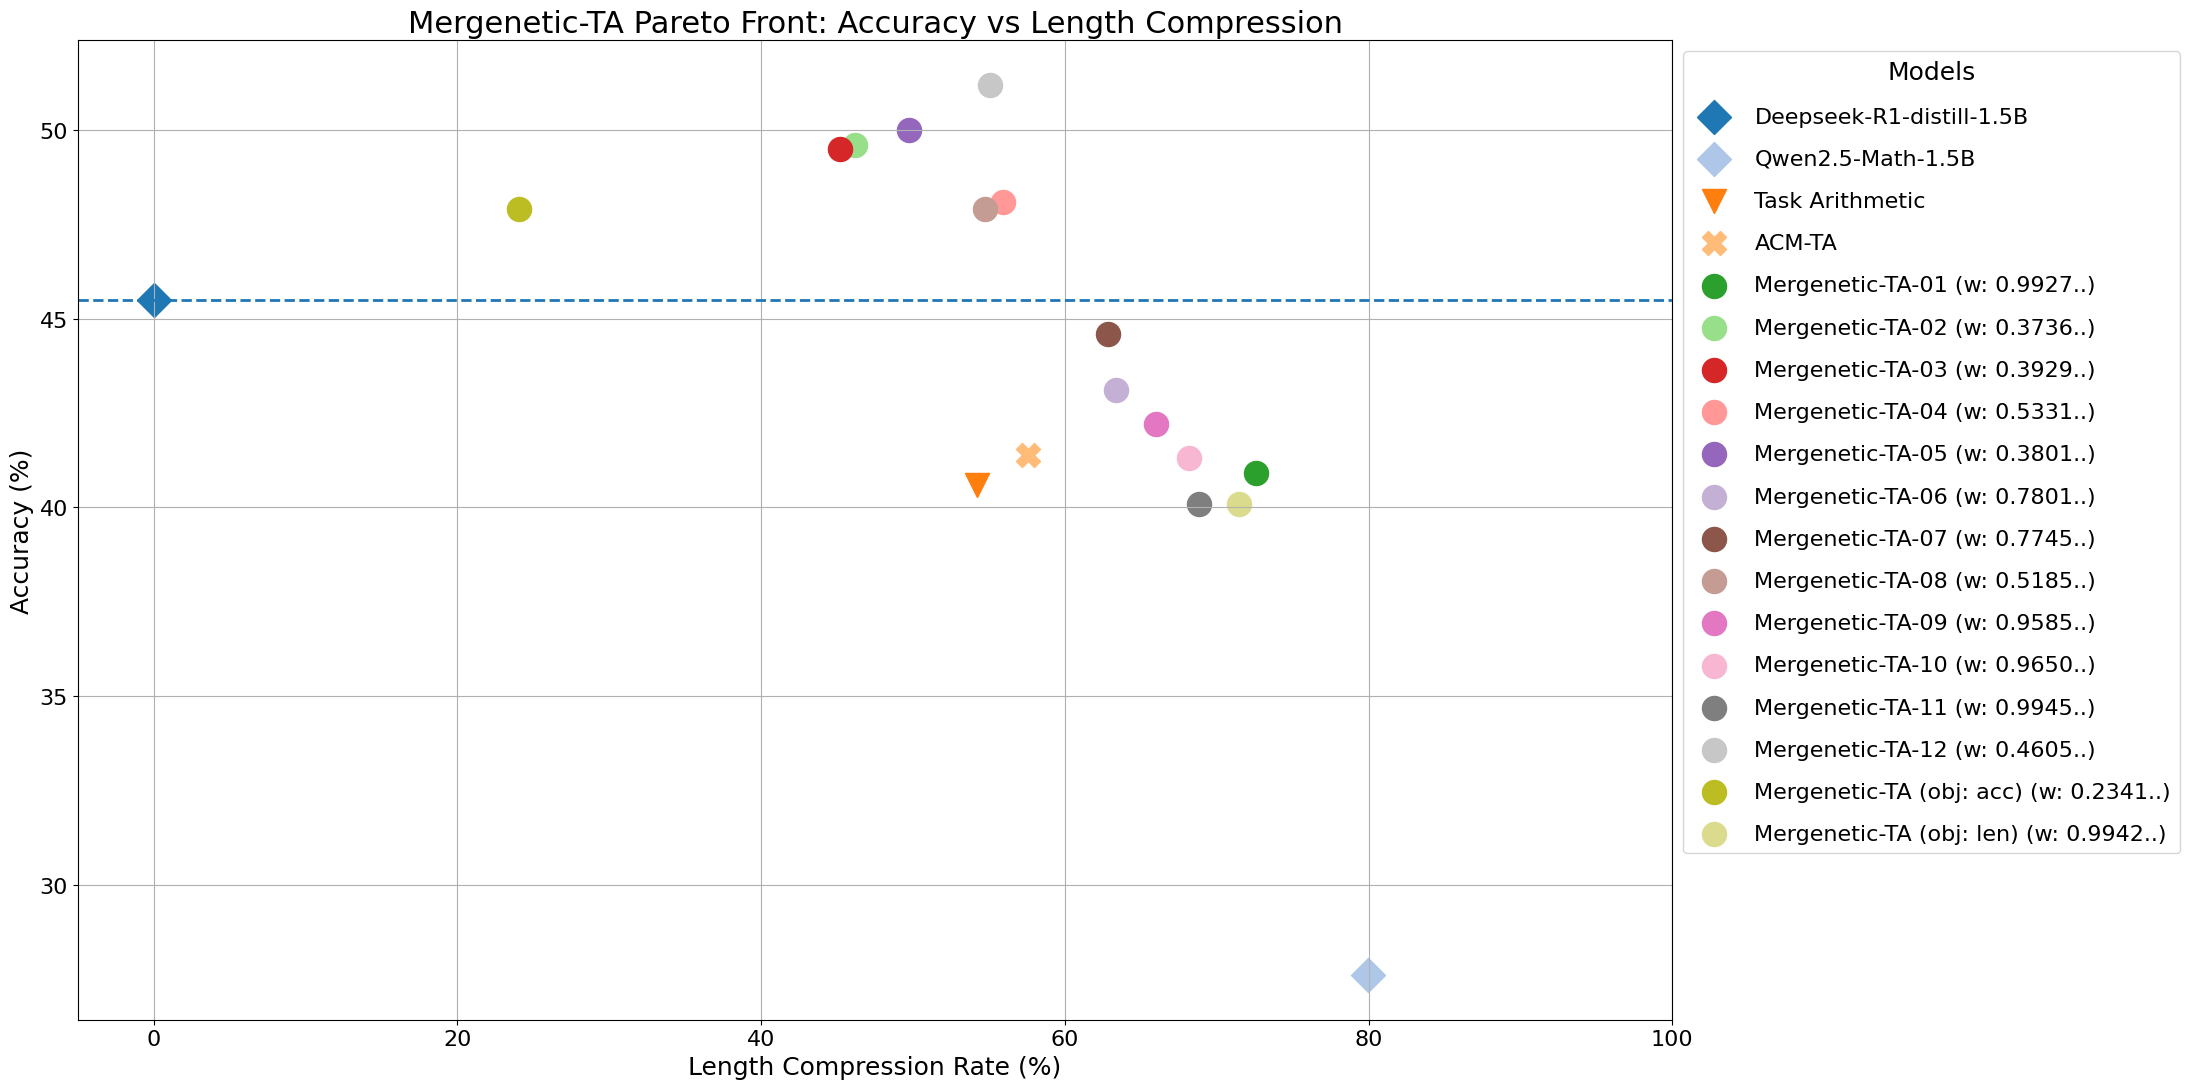

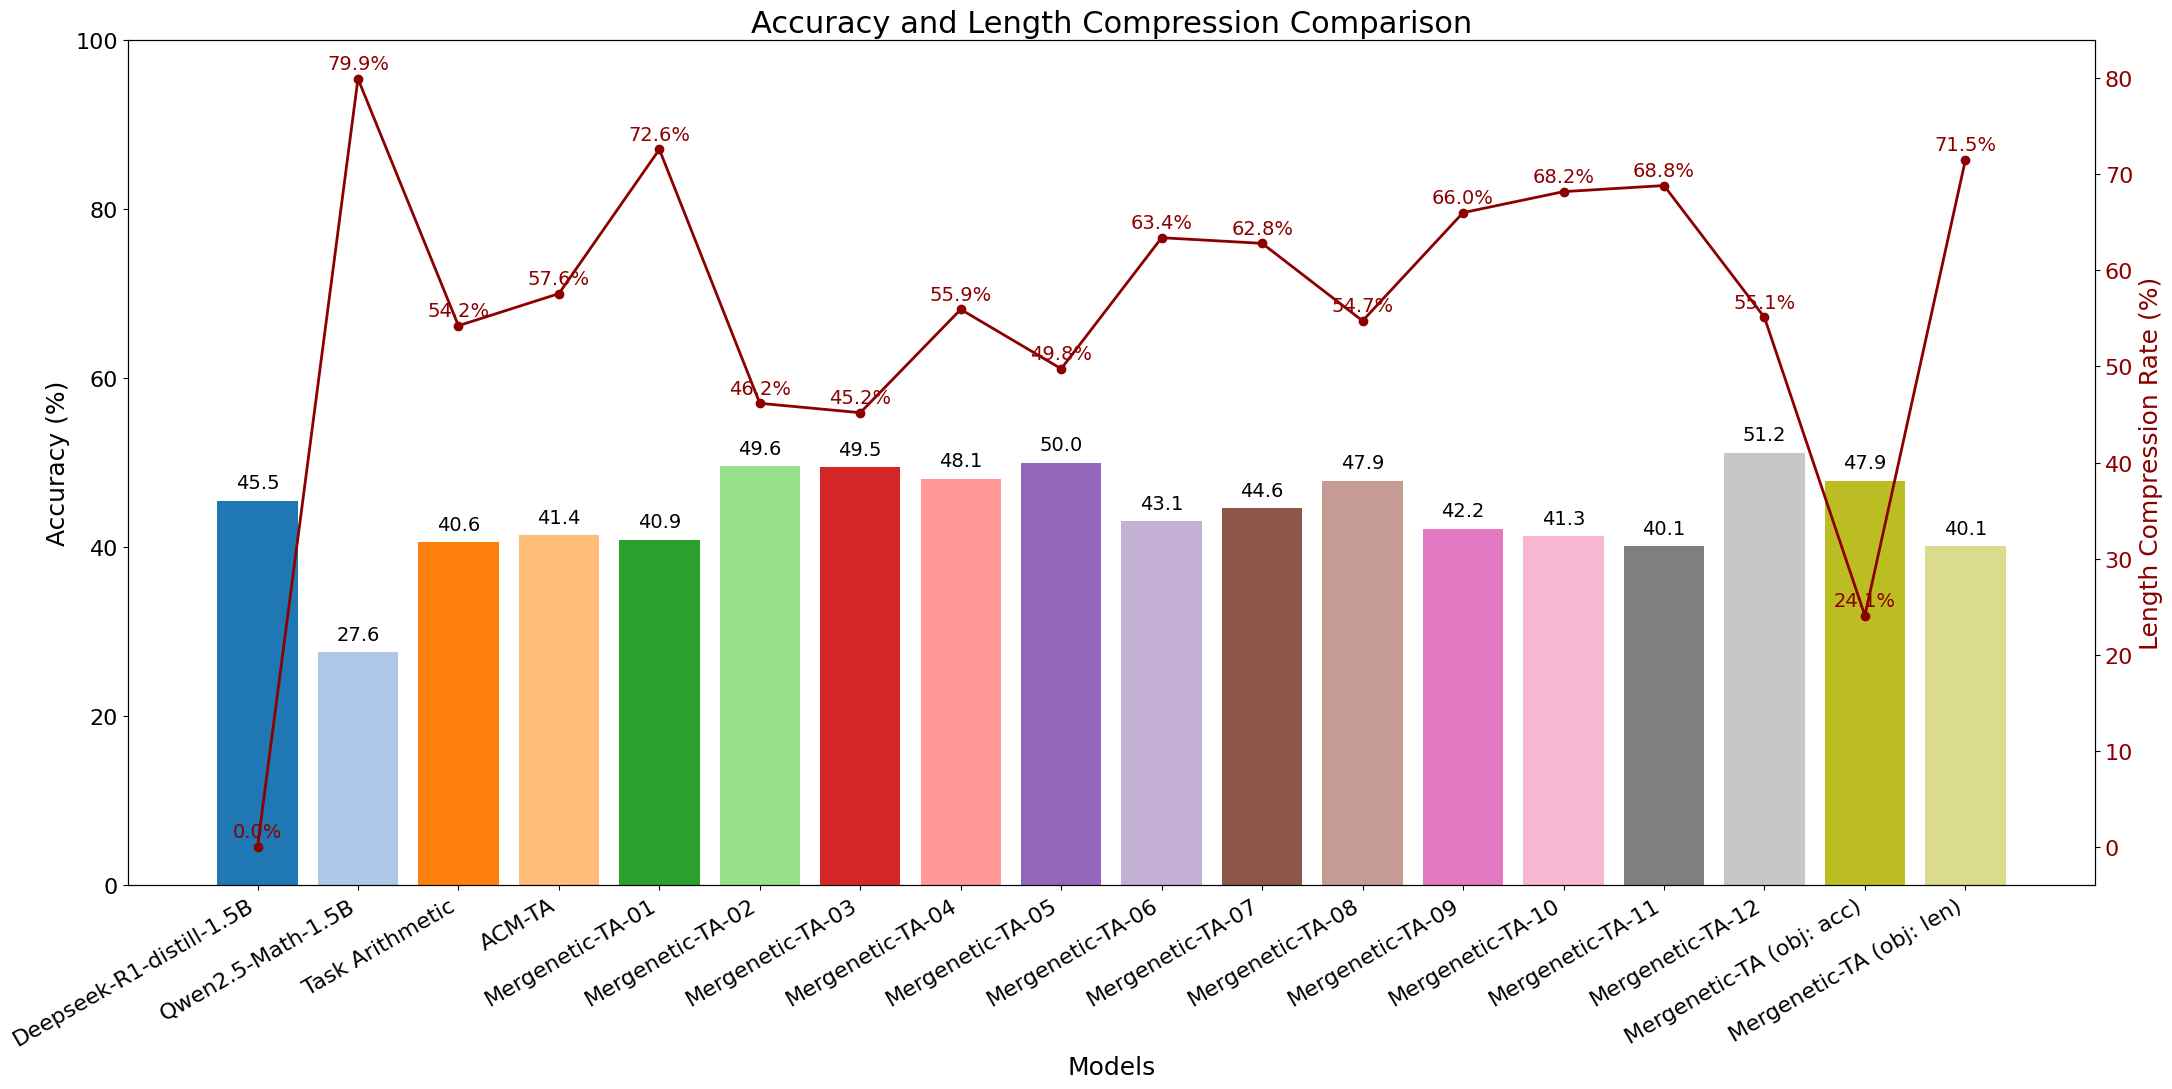

In [5]:
import matplotlib.pyplot as plt

# === Baseline Deepseek ===
deepseek_len = 3756.9
deepseek_acc = 45.5

# === Models ===
models = [
    "Deepseek-R1-distill-1.5B", "Qwen2.5-Math-1.5B", "Task Arithmetic", "ACM-TA",
    "Mergenetic-TA-01", "Mergenetic-TA-02", "Mergenetic-TA-03", "Mergenetic-TA-04", "Mergenetic-TA-05", "Mergenetic-TA-06",
    "Mergenetic-TA-07", "Mergenetic-TA-08", "Mergenetic-TA-09", "Mergenetic-TA-10", "Mergenetic-TA-11", "Mergenetic-TA-12", 
    "Mergenetic-TA (obj: acc)", "Mergenetic-TA (obj: len)"
]

# === Avg. Accuracy (%) per model ===
accuracy = [
    45.5, 27.6, 40.6, 41.4,
    40.9, 49.6, 49.5, 48.1, 50.0, 43.1, 44.6, 47.9, 42.2, 41.3, 40.1, 51.2,
    47.9, 40.1  
]

# === Avg. Length per model ===
lengths = [
    3756.89, 753.5, 1719.1, 1593.68,
    1029.76, 2022.55, 2059.29, 1655.31, 1887.50, 1375.07, 1397.16, 1700.06, 1277.12, 1194.93, 1171.12, 1686.68,
    2852.43, 1071.6  
]

# === Mergenetic-TA Genotypes ===
genotypes = [
    0.9927157617045724, 0.3735654352747948, 0.3928712431443392, 0.5330801245960932, 0.3801086917318549, 0.7801291789745728,
    0.7744903780384856, 0.5184551640436512, 0.9584886817940640, 0.9650342079277739, 0.9945050844202080, 0.4604840932173055,
    0.2341488281053495, 0.9941745065133686
]

# === Compute length Compression Ratio wrt Deepseek-R1 ===
reduction_percent = [100 * (deepseek_len - l) / deepseek_len for l in lengths]

# === Font and colors
FONT_TITLE = 22
FONT_AXIS_LABEL = 18
FONT_TICK = 16
FONT_LEGEND_TITLE = 18
FONT_LEGEND_TEXT = 16
FONT_ANNOTATION = 14
colors = list(plt.cm.tab20.colors)

# === PLOT 1: Accuracy vs Compression Ratio ===
fig, ax = plt.subplots(figsize=(22, 11))

geno_index = 0
for i, (name, acc, red) in enumerate(zip(models, accuracy, reduction_percent)):
    color = colors[i % len(colors)]
    # Marker
    if name in ["Average Merging", "Task Arithmetic", "TIES-Merging"]:
        marker = 'v'  
    elif "Qwen2.5" in name or "Deepseek" in name:
        marker = 'D'
    elif "ACM" in name:
        marker = 'X'
    else:
        marker = 'o'
        
    if "Mergenetic-TA" in name:
        label = f"{name} (w: {genotypes[geno_index]:.4f}..)"
        geno_index += 1
    else:
        label = name

    ax.scatter(red, acc, marker=marker, color=color, s=300, label=label)

ax.set_xlabel("Length Compression Rate (%)", fontsize=FONT_AXIS_LABEL)
ax.set_ylabel("Accuracy (%)", fontsize=FONT_AXIS_LABEL)
ax.set_xlim(-5, 100)
ax.set_title("Mergenetic-TA Pareto Front: Accuracy vs Length Compression", fontsize=FONT_TITLE)
ax.tick_params(axis='both', labelsize=FONT_TICK)
ax.axhline(y=deepseek_acc, color=colors[0], linestyle='--', linewidth=2)
ax.grid(True)

ax.legend(
    title="Models", title_fontsize=FONT_LEGEND_TITLE, fontsize=FONT_LEGEND_TEXT,
    loc='upper left', bbox_to_anchor=(1, 1), labelspacing=1
)

plt.tight_layout()
plt.show()

# === PLOT 2: Accuracy (bar) + Length Compression Ratio (line) ===
fig, ax1 = plt.subplots(figsize=(22, 11))

bars = ax1.bar(models, accuracy, color=colors[:len(models)], alpha=1)
ax1.set_xlabel("Models", fontsize=FONT_AXIS_LABEL)
ax1.set_ylabel("Accuracy (%)", fontsize=FONT_AXIS_LABEL)
ax1.tick_params(axis='y', labelsize=FONT_TICK)
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=30, ha='right', fontsize=FONT_TICK)
ax1.set_ylim(0, 100)

# Accuracy over bars
for bar, acc in zip(bars, accuracy):
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, h + 1, f"{acc:.1f}",
             ha='center', va='bottom', fontsize=FONT_ANNOTATION)

# Secondo axis for length compression
ax2 = ax1.twinx()
ax2.plot(models, reduction_percent, color='darkred', marker='o', linewidth=2)
ax2.set_ylabel("Length Compression Rate (%)", fontsize=FONT_AXIS_LABEL, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred', labelsize=FONT_TICK)

# Reduction values annotation
for i, r in enumerate(reduction_percent):
    ax2.text(i, r + 1, f"{r:.1f}%", color='darkred', fontsize=FONT_ANNOTATION, ha='center')

plt.title("Accuracy and Length Compression Comparison", fontsize=FONT_TITLE)
plt.tight_layout()
plt.show()

#### Mergenetic-TIES (1.5B)

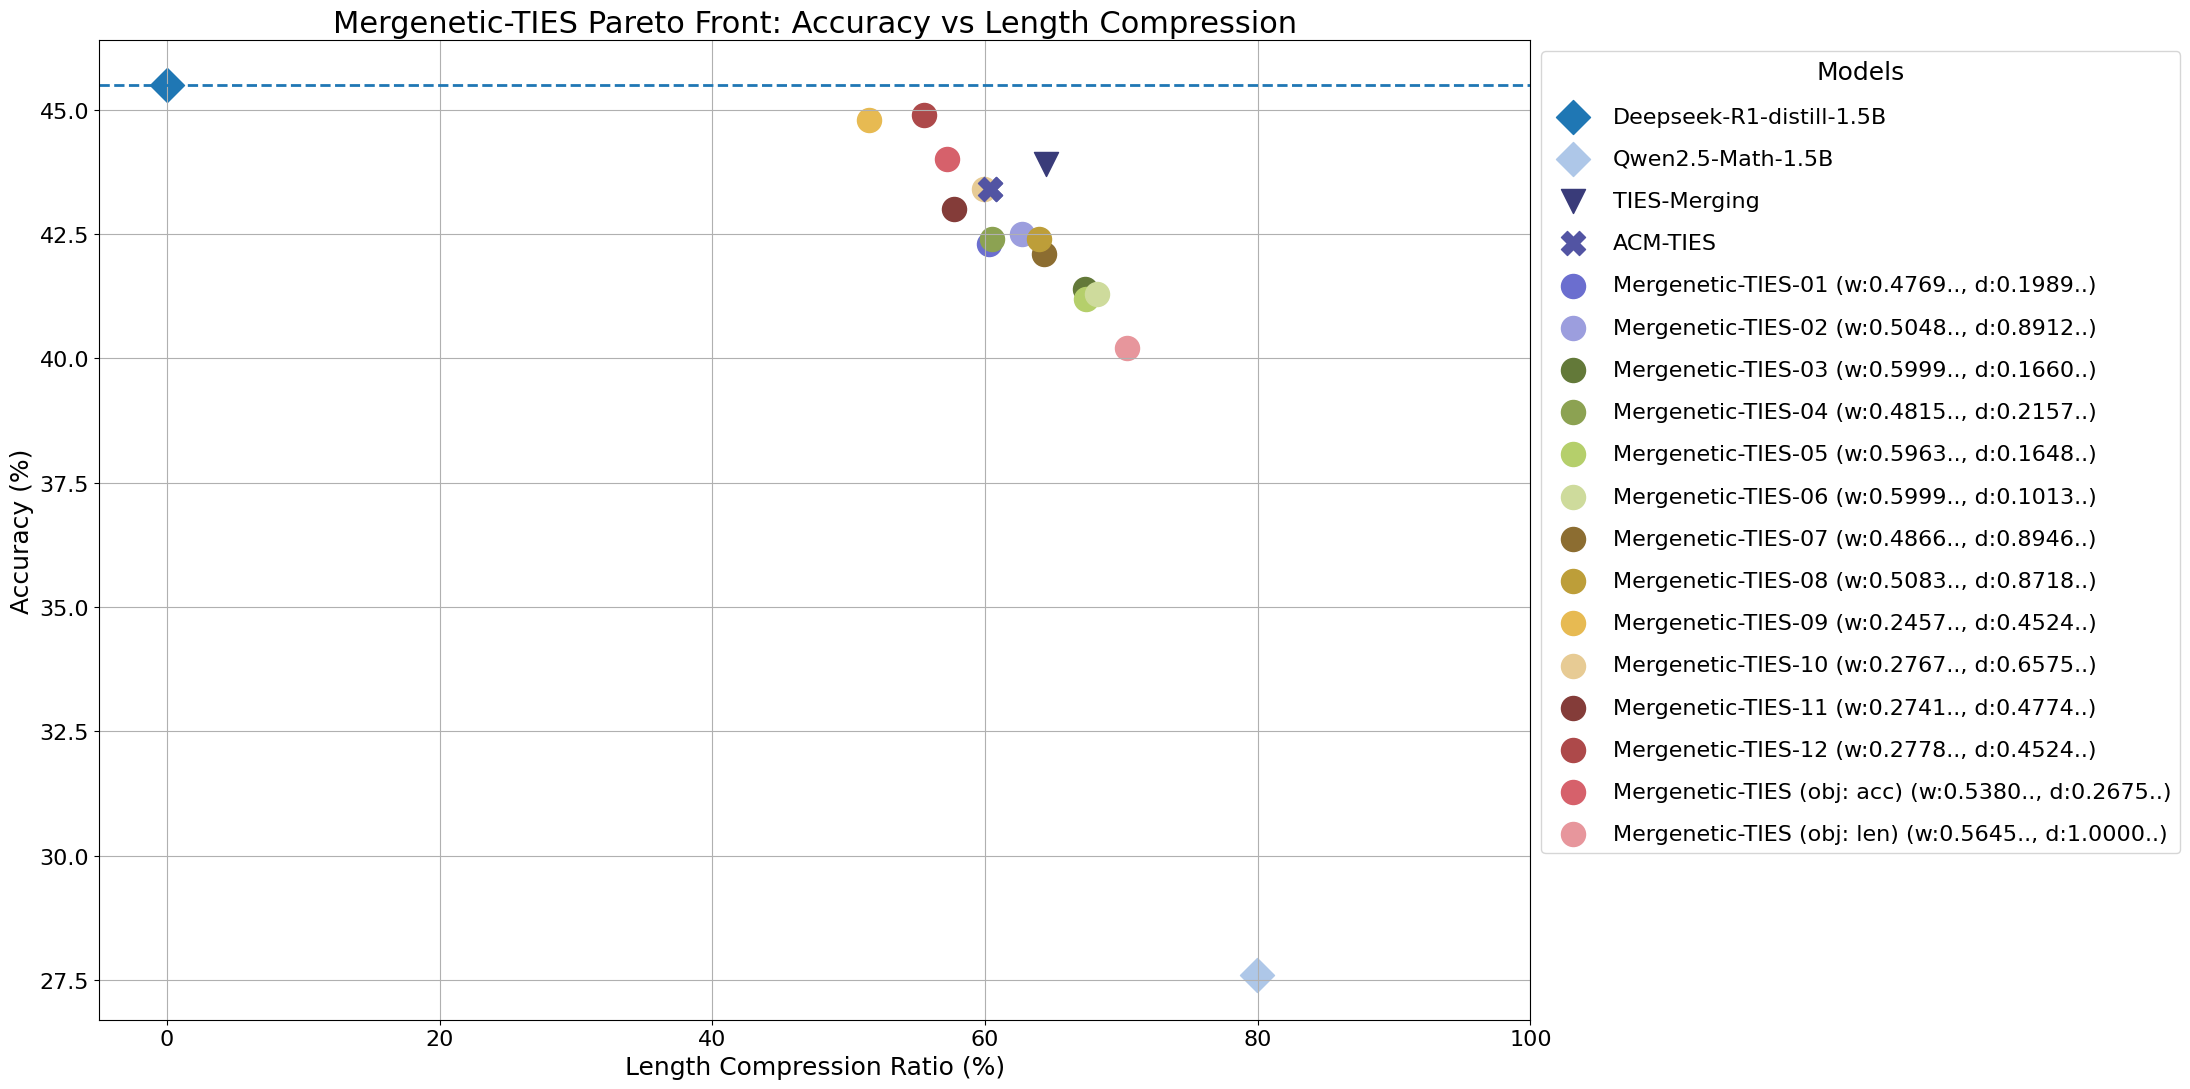

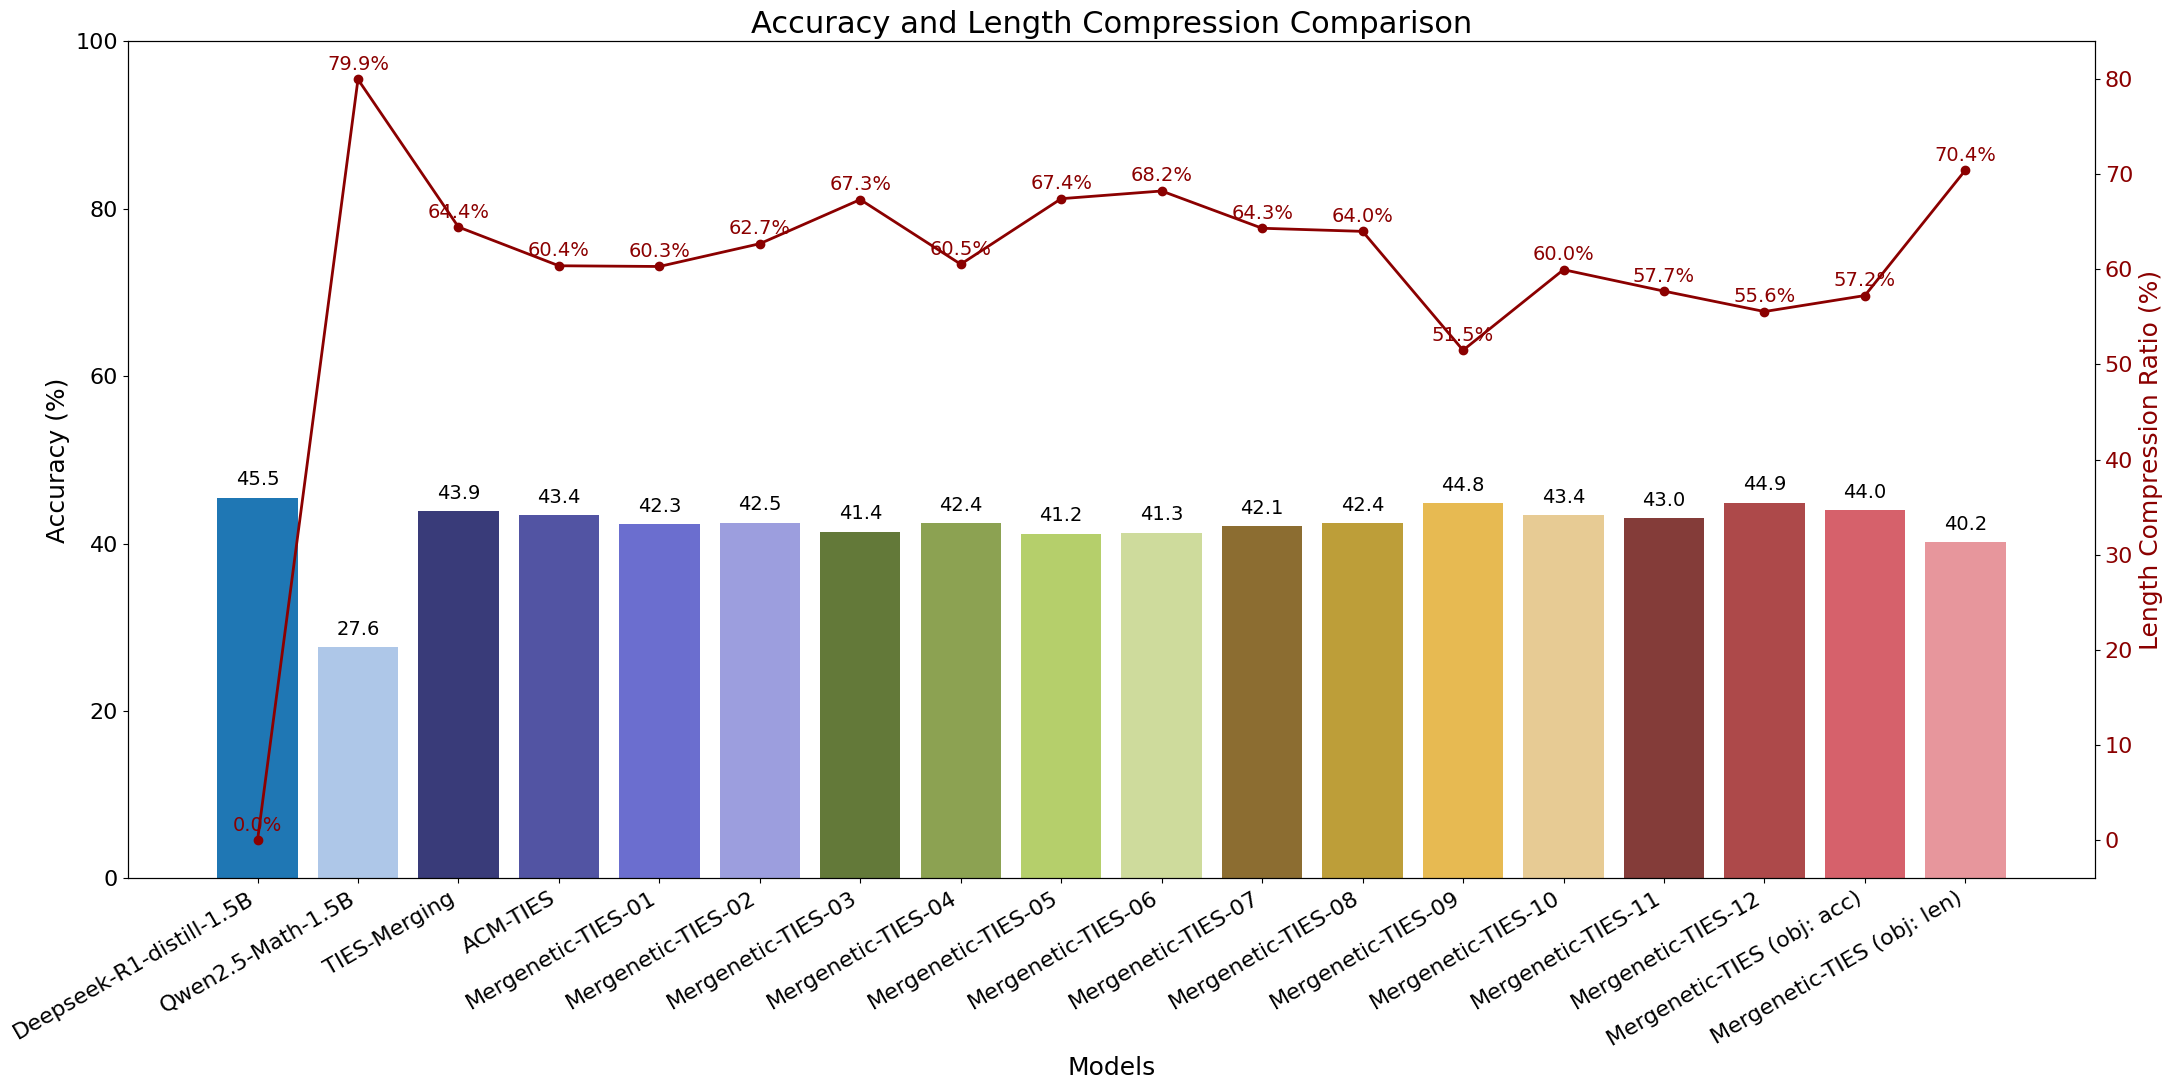

In [6]:
import matplotlib.pyplot as plt

# === Baseline Deepseek ===
deepseek_len = 3756.9
deepseek_acc = 45.5

# === Models ===
models = [
    "Deepseek-R1-distill-1.5B", "Qwen2.5-Math-1.5B", "TIES-Merging", "ACM-TIES",
    "Mergenetic-TIES-01", "Mergenetic-TIES-02", "Mergenetic-TIES-03", "Mergenetic-TIES-04", "Mergenetic-TIES-05", "Mergenetic-TIES-06",
    "Mergenetic-TIES-07", "Mergenetic-TIES-08", "Mergenetic-TIES-09", "Mergenetic-TIES-10", "Mergenetic-TIES-11", "Mergenetic-TIES-12",
    "Mergenetic-TIES (obj: acc)", "Mergenetic-TIES (obj: len)"
]

# === Accuracy ===
accuracy = [
    45.5, 27.6, 43.9 , 43.4,  
    42.3, 42.5, 41.4, 42.4, 41.2, 41.3, 
    42.1, 42.4, 44.8, 43.4, 43.0, 44.9,
    44.0, 40.2
]

# === Avg. Length ===
lengths = [
    3756.9, 753.5, 1336.2, 1489.13,
    1491.95, 1402.04, 1227.84, 1483.03, 1224.36, 1194.00,
    1341.04, 1353.37, 1822.50, 1504.53, 1589.23, 1669.83,
    1606.6, 1111.9 
]

# === Genotypes (w, d) for Mergenetic-TIES models ===
genotypes_d_w = {
    "Mergenetic-TIES-01": (0.19886326513050262, 0.47688537760451843),
    "Mergenetic-TIES-02": (0.8911787168698847,  0.5048038355085174),
    "Mergenetic-TIES-03": (0.16604849835651175, 0.5999142249844713),
    "Mergenetic-TIES-04": (0.21568880650604375, 0.48152384644358814),
    "Mergenetic-TIES-05": (0.16476230763280522, 0.596342268149564),
    "Mergenetic-TIES-06": (0.10128039323704414, 0.5999142249844713),
    "Mergenetic-TIES-07": (0.8945893807182813,  0.48658208893274335),
    "Mergenetic-TIES-08": (0.8718252780593316,  0.5082540191093513),
    "Mergenetic-TIES-09": (0.45238773422632006, 0.24572776354544068),
    "Mergenetic-TIES-10": (0.657464830632376,   0.2767242209987214),
    "Mergenetic-TIES-11": (0.4774412375707893,  0.2740747085577083),
    "Mergenetic-TIES-12": (0.45238773422632006, 0.2777987443392141),
    "Mergenetic-TIES (obj: acc)": (0.267531269095399, 0.5379796572183192),
    "Mergenetic-TIES (obj: len)": (1.0, 0.5645308247032124),
}

# === Length Compression Ratio vs Deepseek ===
reduction_percent = [100 * (deepseek_len - l) / deepseek_len for l in lengths]

labels = []
for name in models:
    if name in genotypes_d_w:
        d, w = genotypes_d_w[name]
        labels.append(f"{name} (w:{w:.4f}.., d:{d:.4f}..)")
    else:
        labels.append(name)

# === Fonts and colors 
FONT_TITLE = 22
FONT_AXIS_LABEL = 18
FONT_TICK = 16
FONT_LEGEND_TITLE = 18
FONT_LEGEND_TEXT = 16
FONT_ANNOTATION = 14
tab20_colors = list(plt.cm.tab20.colors)[:2]
tab20b_colors = list(plt.cm.tab20b.colors)
colors = tab20_colors + tab20b_colors


# PLOT 1: Accuracy vs Compression — ristampo ACM-TIES on top (stesso colore, no legenda)
fig, ax = plt.subplots(figsize=(22, 11))

for i, (lab, acc, red) in enumerate(zip(labels, accuracy, reduction_percent)):
    color = colors[i % len(colors)]
    if "Qwen" in lab or "Deepseek" in lab:
        marker = 'D'
    elif "ACM" in lab:
        marker = 'X'
    elif "TIES-Merging" in lab:
        marker = 'v'  # triangolo verso il basso
    else:
        marker = 'o'
    ax.scatter(red, acc, marker=marker, color=color, s=300, label=lab)

acm_idx = models.index("ACM-TIES")
acm_color = colors[acm_idx % len(colors)]
ax.scatter(reduction_percent[acm_idx], accuracy[acm_idx],
           marker='X', color=acm_color, s=300, label="_nolegend_", zorder=6)

ax.set_xlabel("Length Compression Ratio (%)", fontsize=FONT_AXIS_LABEL)
ax.set_ylabel("Accuracy (%)", fontsize=FONT_AXIS_LABEL)
ax.set_xlim(-5, 100)
ax.set_title("Mergenetic-TIES Pareto Front: Accuracy vs Length Compression", fontsize=FONT_TITLE)
ax.tick_params(axis='both', labelsize=FONT_TICK)
ax.axhline(y=deepseek_acc, color=colors[0], linestyle='--', linewidth=2)
ax.grid(True)

handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(),
          title="Models", title_fontsize=FONT_LEGEND_TITLE,
          fontsize=FONT_LEGEND_TEXT, loc='upper left', bbox_to_anchor=(1, 1), labelspacing=1)

plt.tight_layout()
plt.show()

# PLOT 2: Accuracy (bar) + Compression (line)
fig, ax1 = plt.subplots(figsize=(22, 11))
bars = ax1.bar(models, accuracy, color=colors[:len(models)], alpha=1)
ax1.set_xlabel("Models", fontsize=FONT_AXIS_LABEL)
ax1.set_ylabel("Accuracy (%)", fontsize=FONT_AXIS_LABEL)
ax1.tick_params(axis='y', labelsize=FONT_TICK)
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=30, ha='right', fontsize=FONT_TICK)
ax1.set_ylim(0, 100)

# Accuracy annotations
for bar, acc in zip(bars, accuracy):
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, h + 1, f"{acc:.1f}",
             ha='center', va='bottom', fontsize=FONT_ANNOTATION)

# Compression lines
ax2 = ax1.twinx()
ax2.plot(models, reduction_percent, color='darkred', marker='o', linewidth=2)
ax2.set_ylabel("Length Compression Ratio (%)", fontsize=FONT_AXIS_LABEL, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred', labelsize=FONT_TICK)

for i, r in enumerate(reduction_percent):
    ax2.text(i, r + 1, f"{r:.1f}%", color='darkred', fontsize=FONT_ANNOTATION, ha='center')

plt.title("Accuracy and Length Compression Comparison", fontsize=FONT_TITLE)
plt.tight_layout()
plt.show()

#### Mergenetic-TA (7B)

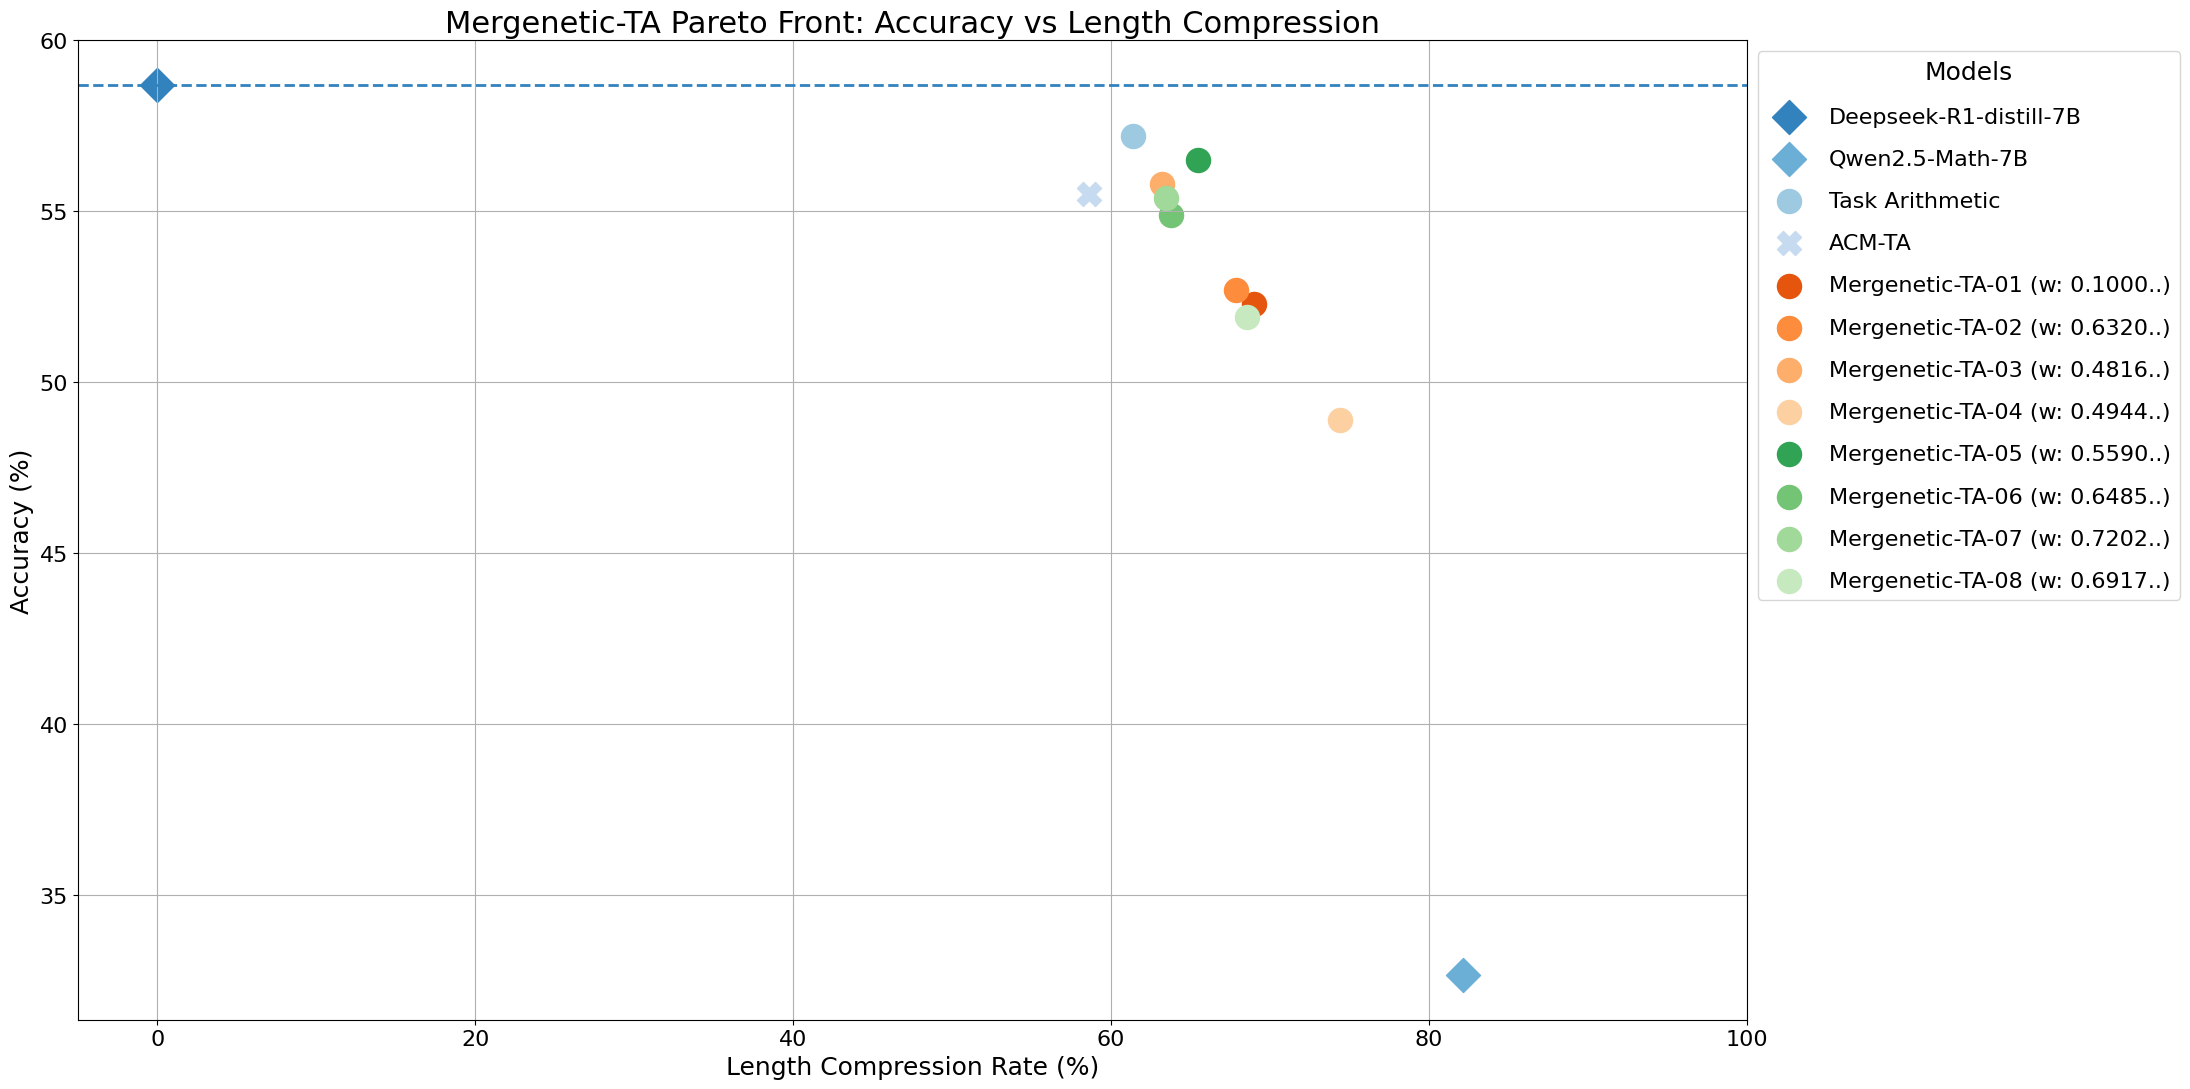

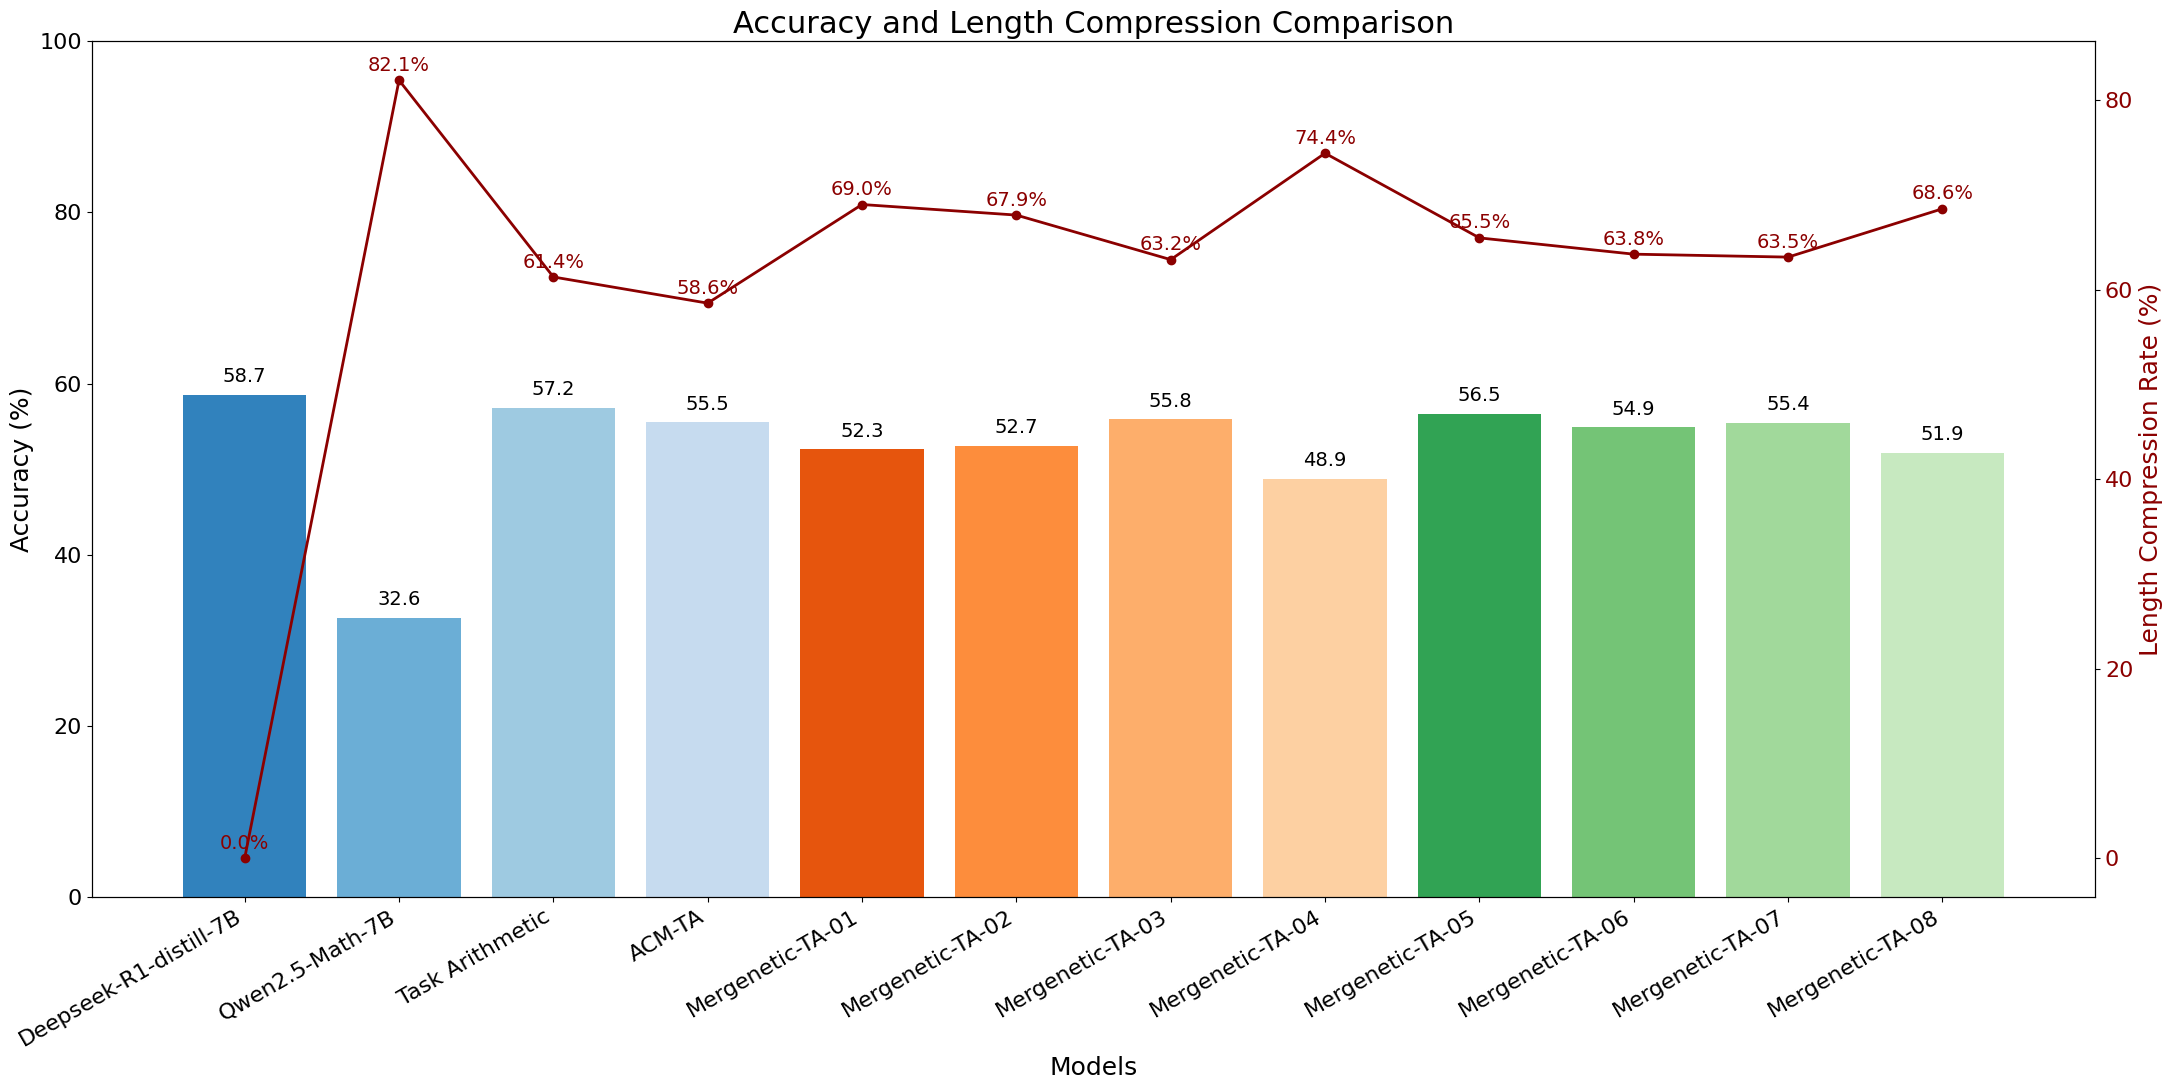

In [21]:
import matplotlib.pyplot as plt

# === Baseline Deepseek-Math ===
deepseek_len = 4593.51
deepseek_acc = 58.7

# === Modelli inclusi ===
models = ["Deepseek-R1-distill-7B", "Qwen2.5-Math-7B", "Task Arithmetic", "ACM-TA","Mergenetic-TA-01", "Mergenetic-TA-02", "Mergenetic-TA-03", "Mergenetic-TA-04", "Mergenetic-TA-05", "Mergenetic-TA-06", "Mergenetic-TA-07", "Mergenetic-TA-08"  ]

# === Avg. Accuracy (%) ===
accuracy = [58.7, 32.65, 57.2, 55.5, 52.3, 52.7, 55.8, 48.9, 56.5, 54.9, 55.4, 51.9]

# === Avg. Length ===
lengths = [4593.51, 820.88, 1775.20, 1902.20, 1423.72, 1475.01, 1691.11, 1174.95, 1585.62, 1664.57, 1678.84, 1444.51]

# === Genotypes per Mergenetic-TA  ===
genotypes = [0.10000000000000000555, 0.63204607917448796250, 0.48158357351823299908, 0.49440083478604918144, 0.55898188326488118527, 0.64851132461316873812, 0.72016559488879861028, 0.69170067746171537415]

# === Calcolo riduzione lunghezza rispetto a Deepseek-Math ===
reduction_percent = [100 * (deepseek_len - l) / deepseek_len for l in lengths]

# === Colori ===
colors = list(plt.cm.tab20c.colors)

# === Font constants ===
FONT_TITLE = 22
FONT_AXIS_LABEL = 18
FONT_TICK = 16
FONT_LEGEND_TITLE = 18
FONT_LEGEND_TEXT = 16
FONT_ANNOTATION = 14

# === PLOT 1: Accuracy vs Riduzione Lunghezza ===
fig, ax = plt.subplots(figsize=(22, 11))

geno_index = 0
for i, (name, acc, red) in enumerate(zip(models, accuracy, reduction_percent)):
    color = colors[i % len(colors)]
    if "Qwen2.5" in name or "Deepseek" in name:
        marker = 'D'
    elif "ACM" in name:
        marker = 'X'
    else:
        marker = 'o'

    if "Mergenetic-TA" in name and geno_index < len(genotypes):
        label = f"{name} (w: {genotypes[geno_index]:.4f}..)"
        geno_index += 1
    else:
        label = name

    ax.scatter(red, acc, marker=marker, color=color, s=300, label=label)

ax.set_xlabel("Length Compression Rate (%)", fontsize=FONT_AXIS_LABEL)
ax.set_ylabel("Accuracy (%)", fontsize=FONT_AXIS_LABEL)
ax.set_xlim(-5, 100)
ax.set_title("Mergenetic-TA Pareto Front: Accuracy vs Length Compression", fontsize=FONT_TITLE)
ax.tick_params(axis='both', labelsize=FONT_TICK)
ax.axhline(y=deepseek_acc, color=colors[0], linestyle='--', linewidth=2)
ax.grid(True)

ax.legend(
    title="Models", title_fontsize=FONT_LEGEND_TITLE, fontsize=FONT_LEGEND_TEXT,
    loc='upper left', bbox_to_anchor=(1, 1), labelspacing=1
)

plt.tight_layout()
plt.show()

# === PLOT 2: Accuracy (bar) + Length Reduction (line) ===
fig, ax1 = plt.subplots(figsize=(22, 11))

bars = ax1.bar(models, accuracy, color=colors[:len(models)], alpha=1)
ax1.set_xlabel("Models", fontsize=FONT_AXIS_LABEL)
ax1.set_ylabel("Accuracy (%)", fontsize=FONT_AXIS_LABEL)
ax1.tick_params(axis='y', labelsize=FONT_TICK)
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=30, ha='right', fontsize=FONT_TICK)
ax1.set_ylim(0, 100)

for bar, acc in zip(bars, accuracy):
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, h + 1, f"{acc:.1f}",
             ha='center', va='bottom', fontsize=FONT_ANNOTATION)

# Secondo asse Y per riduzione lunghezza
ax2 = ax1.twinx()
ax2.plot(models, reduction_percent, color='darkred', marker='o', linewidth=2)
ax2.set_ylabel("Length Compression Rate (%)", fontsize=FONT_AXIS_LABEL, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred', labelsize=FONT_TICK)

for i, r in enumerate(reduction_percent):
    ax2.text(i, r + 1, f"{r:.1f}%", color='darkred', fontsize=FONT_ANNOTATION, ha='center')

plt.title("Accuracy and Length Compression Comparison", fontsize=FONT_TITLE)
plt.tight_layout()
plt.show()

#### Radar Plot

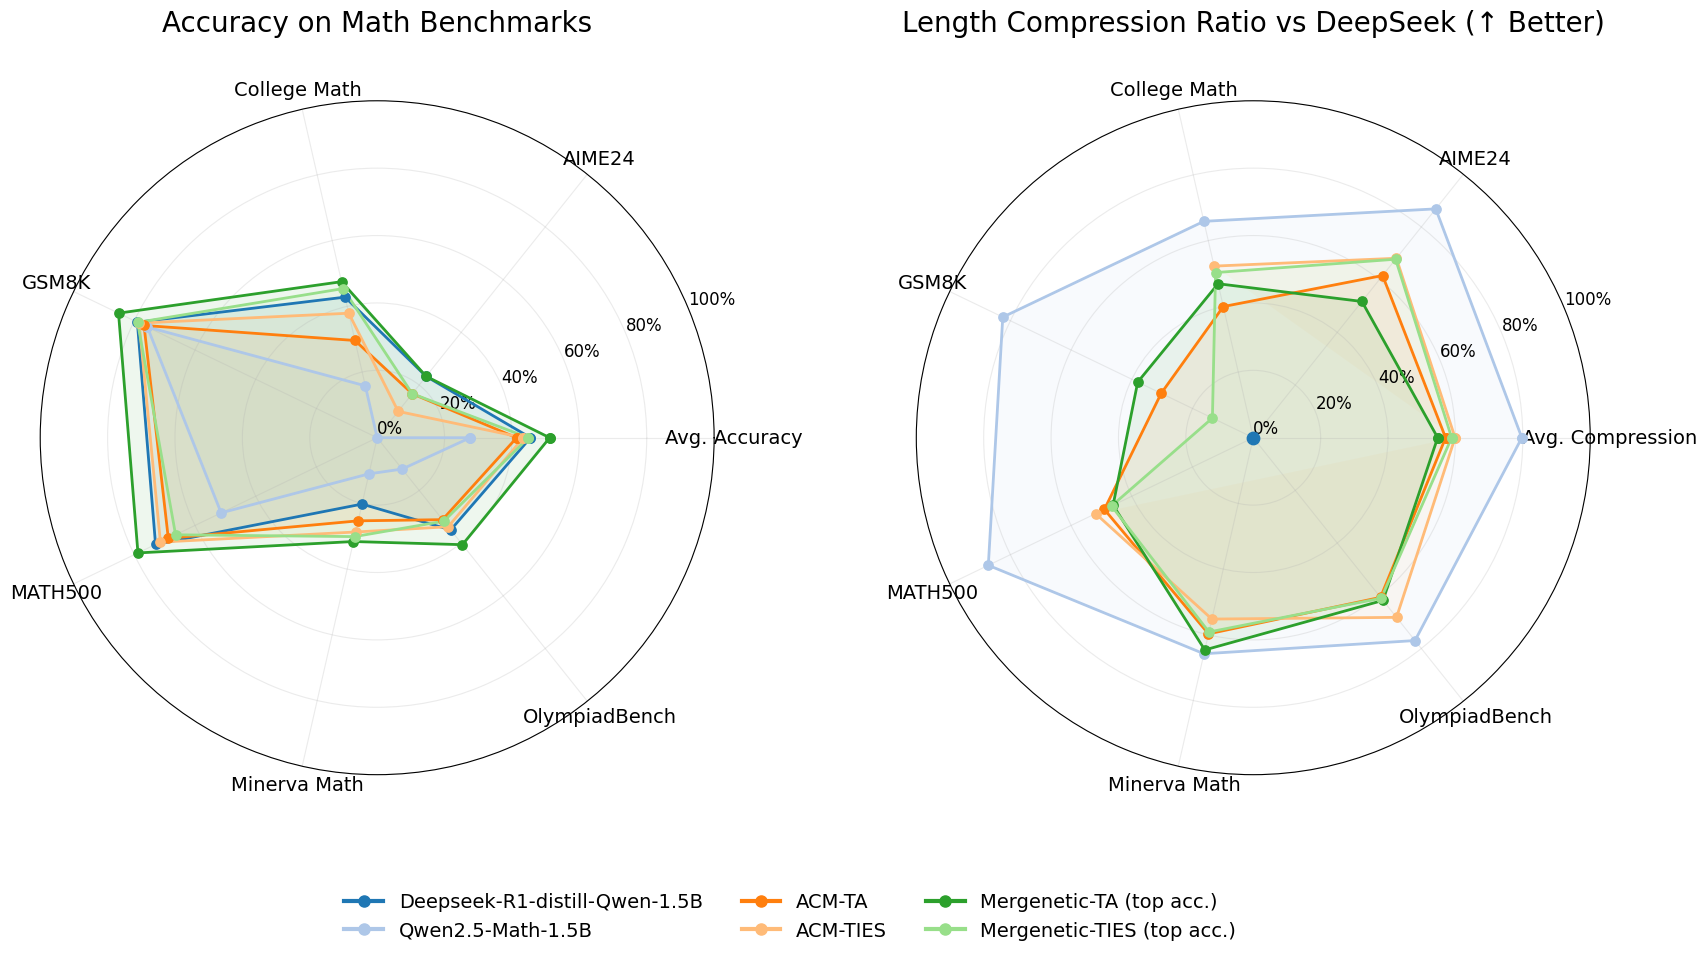

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import pi

# === Common labels ===
acc_labels = ['Avg. Accuracy', 'AIME24', 'College Math', 'GSM8K', 'MATH500', 'Minerva Math', 'OlympiadBench']
comp_labels = ['Avg. Compression', 'AIME24', 'College Math', 'GSM8K', 'MATH500', 'Minerva Math', 'OlympiadBench']
n_labels = len(acc_labels)

# === Accuracy data (in %) ===
acc_data = {
    'Deepseek-R1-distill-Qwen-1.5B': [45.5, 23.3, 42.8, 79.0, 73.0, 20.2, 35.0],
    'Qwen2.5-Math-1.5B':             [27.6,  0.0, 15.8, 75.7, 51.4, 11.0, 11.9],
    'ACM-TA':                        [41.4, 16.7, 29.6, 76.8, 68.8, 25.3, 31.1],
    'ACM-TIES':                      [43.4, 10.0, 37.9, 78.4, 71.4, 28.7, 33.8],
    'Mergenetic-TA (top acc.)':      [51.2, 23.3, 47.5, 85.2, 78.8, 31.6, 40.6],
    'Mergenetic-TIES (top acc.)':    [44.9, 16.7, 45.4, 78.9, 66.4, 30.1, 31.7],
}

# === Length data (tokens) ===
len_data = {
    'Deepseek-R1-distill-Qwen-1.5B': [3756.89, 8432.93, 1776.60, 628.74, 2570.01, 3014.85, 5814.21],
    'Qwen2.5-Math-1.5B':             [753.5,  1107.50,  606.30, 110.00,  327.20, 1032.20, 1337.70],
    'ACM-TA':                        [1593.68, 3240.90, 1067.30, 438.00, 1309.60, 1214.70, 2291.60],
    'ACM-TIES':                      [1489.13, 2688.50,  848.50, 962.10, 1235.60, 1350.50, 1849.60],
    'Mergenetic-TA (top acc.)':      [1686.68, 4071.43,  943.80, 389.46, 1383.28, 1067.35, 2223.76],
    'Mergenetic-TIES (top acc.)':    [1669.83, 2718.97,  883.43, 544.14, 1370.32, 1231.92, 2272.19],
}

# === Colors ===
colors = plt.cm.tab20.colors
order = list(acc_data.keys())
color_map = {name: colors[i] for i, name in enumerate(order)}

# === Angles ===
angles = [n / float(n_labels) * 2 * pi for n in range(n_labels)]
angles += angles[:1]  # close the polygon

# === Figure ===
fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(20, 10))

# ---------- Plot 1: Accuracy ----------
axs[0].set_title("Accuracy on Math Benchmarks", size=20, pad=50)
axs[0].set_xticks(angles[:-1])
axs[0].set_xticklabels(acc_labels, fontsize=14)
axs[0].set_ylim(0, 100)
axs[0].set_yticks([0, 20, 40, 60, 80, 100])
axs[0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"], fontsize=12)
axs[0].grid(alpha=0.25)

for name in order:
    vals = acc_data[name] + acc_data[name][:1]
    axs[0].plot(angles, vals, color=color_map[name], linewidth=2)
    axs[0].scatter(angles, vals, color=color_map[name], s=45, zorder=3)
    axs[0].fill(angles, vals, alpha=0.08, color=color_map[name])

# ---------- Plot 2: Compression (% reduction vs DeepSeek) ----------
deepseek = len_data['Deepseek-R1-distill-Qwen-1.5B']

# Compute average length per model to prepend as "Avg. Compression"
def avg(lst): return sum(lst) / len(lst)

comp_data = {}
for name, lengths in len_data.items():
    if name == 'Deepseek-R1-distill-Qwen-1.5B':
        # We'll plot DeepSeek as a single dot at the center (0% compression), no polygon.
        continue
    # % reduction vs DeepSeek for each axis (including Avg.)
    reductions = []
    reductions.append((1 - (avg(lengths) / avg(deepseek))) * 100)  # Avg. Compression
    for i in range(1, len(lengths)):  # per-dataset, skip avg we just computed
        reductions.append((1 - (lengths[i] / deepseek[i])) * 100)
    # NOTE: The arrays in len_data begin with avg length; we aligned labels accordingly.
    comp_data[name] = reductions

axs[1].set_title("Length Compression Ratio vs DeepSeek (↑ Better)", size=20, pad=50)
axs[1].set_xticks(angles[:-1])
axs[1].set_xticklabels(comp_labels, fontsize=14)
axs[1].set_ylim(0, 100)
axs[1].set_yticks([0, 20, 40, 60, 80, 100])
axs[1].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"], fontsize=12)
axs[1].grid(alpha=0.25)

# Plot other models' polygons
for name, reductions in comp_data.items():
    vals = reductions + reductions[:1]
    axs[1].plot(angles, vals, color=color_map[name], linewidth=2)
    axs[1].scatter(angles, vals, color=color_map[name], s=45, zorder=3)
    axs[1].fill(angles, vals, alpha=0.08, color=color_map[name])

# Add a single DeepSeek marker at the center (0% compression)
axs[1].scatter([0], [0], color=color_map['Deepseek-R1-distill-Qwen-1.5B'],
               s=80, zorder=4, label='Deepseek-R1-distill-Qwen-1.5B')

# ---------- Unified legend (include DeepSeek) ----------
legend_handles = [
    Line2D([0], [0],
           color=color_map[name],
           linewidth=3,
           marker='o',
           markersize=8,
           markerfacecolor=color_map[name],
           markeredgecolor=color_map[name])
    for name in order
]
fig.legend(
    legend_handles,
    order,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    fontsize=14,
    ncol=3,
    frameon=False
)

plt.subplots_adjust(top=0.85, bottom=0.15, wspace=0.3)
plt.show()

## 🔄 Negative Transfer Rate (NTR)



Let's define the following binary variables:
- $Y_{i, m_j} \in \{0, 1\}$: 1 if **base model** $m_j$ answers sample $i$ correctly, 0 otherwise  
- $Y_{i, \tilde{m}} \in \{0, 1\}$: 1 if the **merged model** $\tilde{m}$ answers sample $i$ correctly, 0 otherwise

We define **Negative Transfer** for sample \( i \) as:

$$
\exists \,\, j \in \{1, \dots, K\} \text{ such that } Y_{i,m_j} = 1 \text{ and } Y_{i,\tilde{m}} = 0
$$

This means: *at least one base model was correct, but the merged model failed*.

 **Negative Transfer Index (NTI)**

Let $n_i = 1$ if negative transfer occurs for example $i$, and $0$ otherwise.  

Then, the **Negative Transfer Rate (NTR)** is defined as:

- The **numerator** counts examples with negative transfer  
- The **denominator** counts examples where at least one base model was correct


Interpretation

- **Lower NTR is better** — it means the merged model preserves base model knowledge  
- **High NTI** indicates **knowledge loss** from merging, and potential performance degradation



In [ ]:
# Execute this function to extract binary tensor scores for each task
!python generate_score_tensors.py \
    --base_dir outputs/Mergenetic-TA-Multiobj/7B/01

In [16]:
# Execute this function to compute per task and overall NTR score
!python compute_NTR.py \
  --base1_dir outputs/DEEPSEEK-R1/1.5B/scores \
  --base2_dir outputs/QWEN25-MATH/1.5B/scores \
  --merged_dir outputs/Mergenetic-TA-Multiobj/1.5B/12/scores

/Users/iacobelli/Downloads/DLAI-project/Qwen2.5-Math/evaluation/compute_NTR.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base1 = torch.load(base1_files[task]).bool()

### Mergenetic-TA (1.5B) NTR

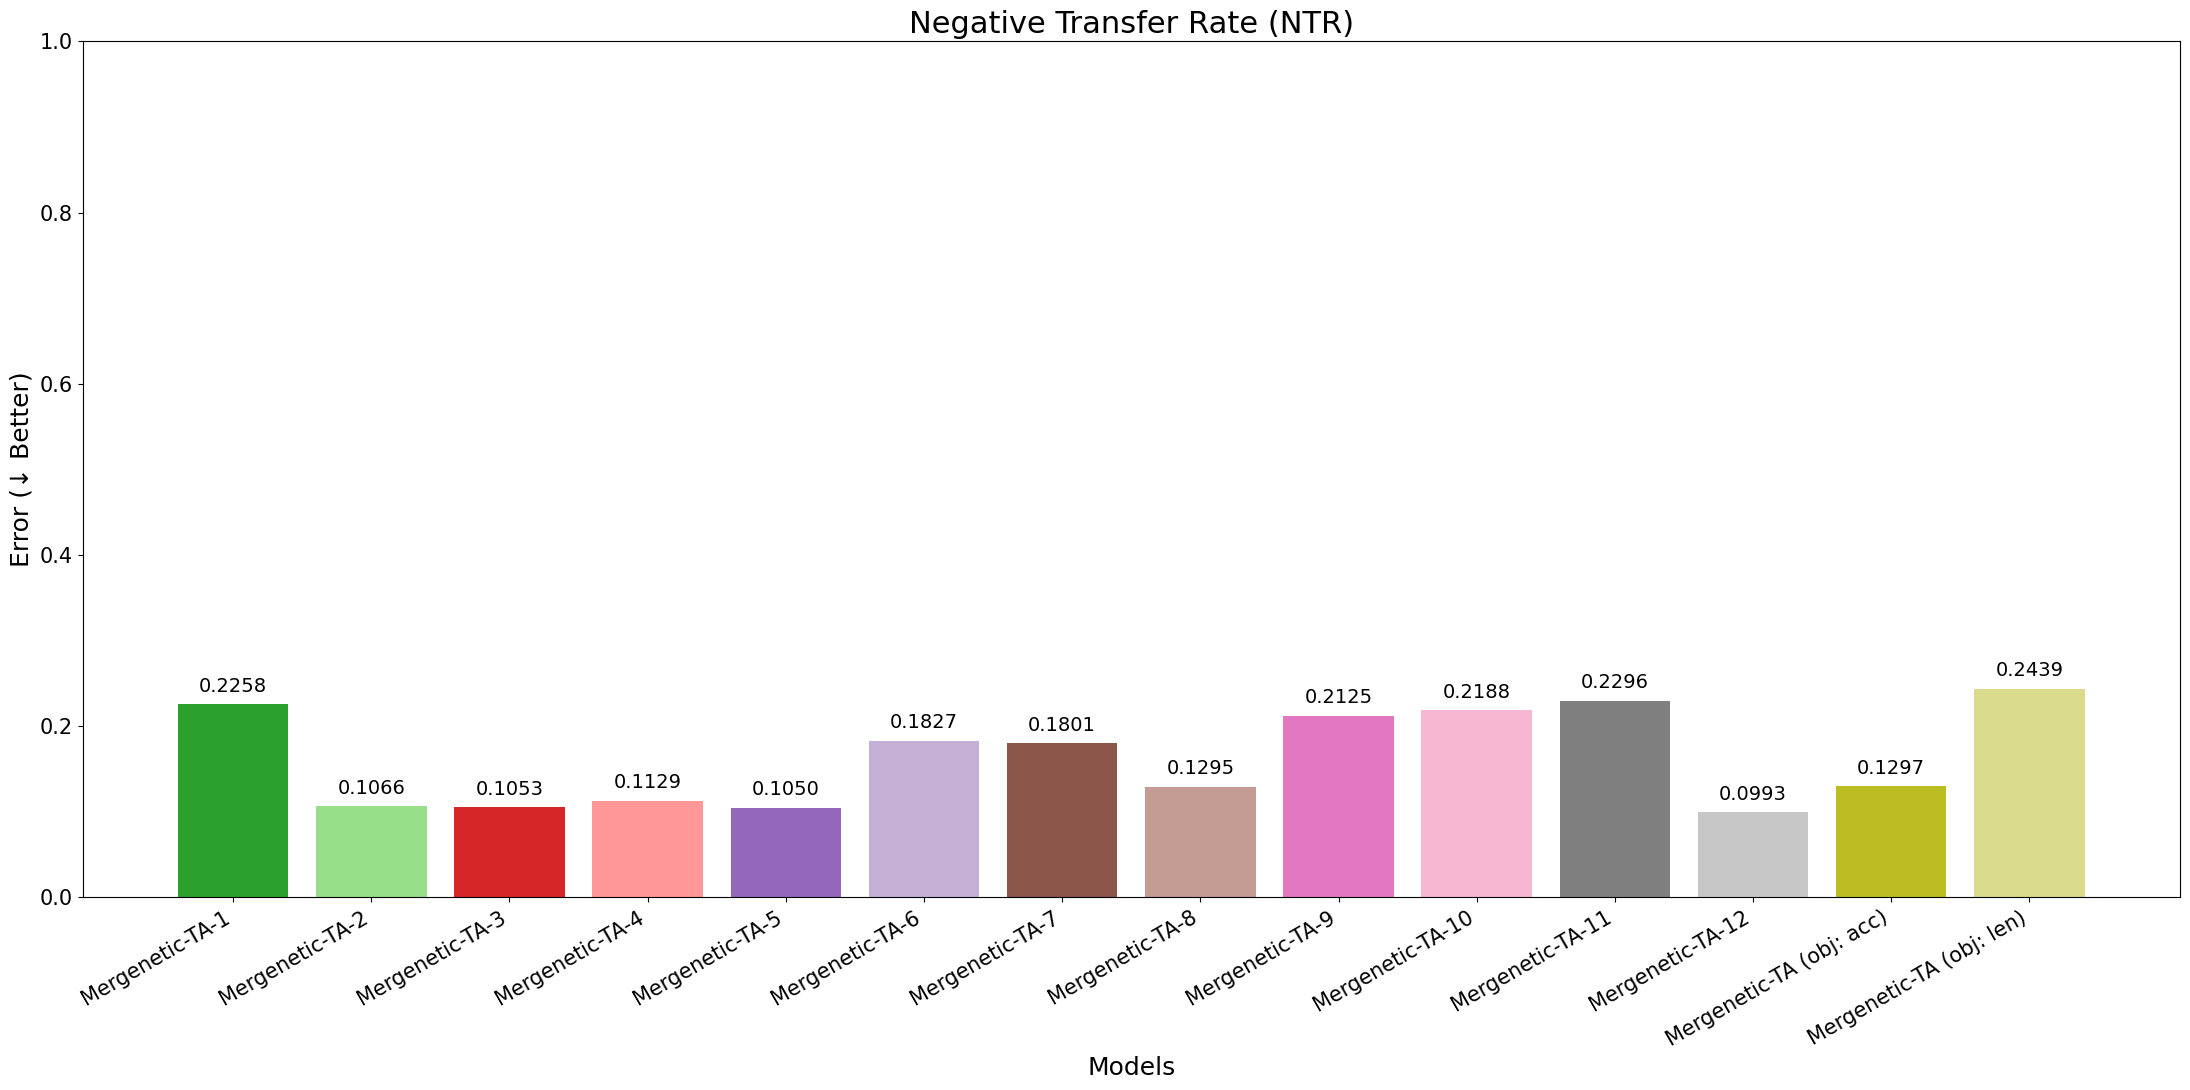

In [19]:
import matplotlib.pyplot as plt

# === Models ===
Mergenetic_TA_models = [
    "Mergenetic-TA-1", "Mergenetic-TA-2", "Mergenetic-TA-3", "Mergenetic-TA-4", "Mergenetic-TA-5",
    "Mergenetic-TA-6", "Mergenetic-TA-7", "Mergenetic-TA-8", "Mergenetic-TA-9", "Mergenetic-TA-10",
    "Mergenetic-TA-11",  "Mergenetic-TA-12",
    "Mergenetic-TA (obj: acc)", "Mergenetic-TA (obj: len)"
]

# === NTR scores ===
Mergenetic_TA_NTR = [0.2258, 0.1066, 0.1053, 0.1129, 0.1050,
                     0.1827, 0.1801, 0.1295, 0.2125, 0.2188,
                     0.2296, 0.0993, 0.1297, 0.2439]

# === Fonts and colors
FONT_TITLE = 22
FONT_AXIS_LABEL = 18
FONT_TICK = 15
FONT_ANNOTATION = 14
colors = list(plt.cm.tab20.colors[4:])

# === Plot
plt.figure(figsize=(22, 11))
bars = plt.bar(Mergenetic_TA_models, Mergenetic_TA_NTR, color=colors)

# Aggiungi valore sopra ogni barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f"{Mergenetic_TA_NTR[i]:.4f}", ha='center', va='bottom', fontsize=FONT_ANNOTATION)

plt.ylabel("Error (↓ Better)", fontsize=FONT_AXIS_LABEL)
plt.xlabel("Models", fontsize=FONT_AXIS_LABEL)
plt.title("Negative Transfer Rate (NTR)", fontsize=FONT_TITLE)
plt.xticks(rotation=30, ha="right", fontsize=FONT_TICK)
plt.yticks(fontsize=FONT_TICK)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Mergenetic-TIES (1.5B) NTR

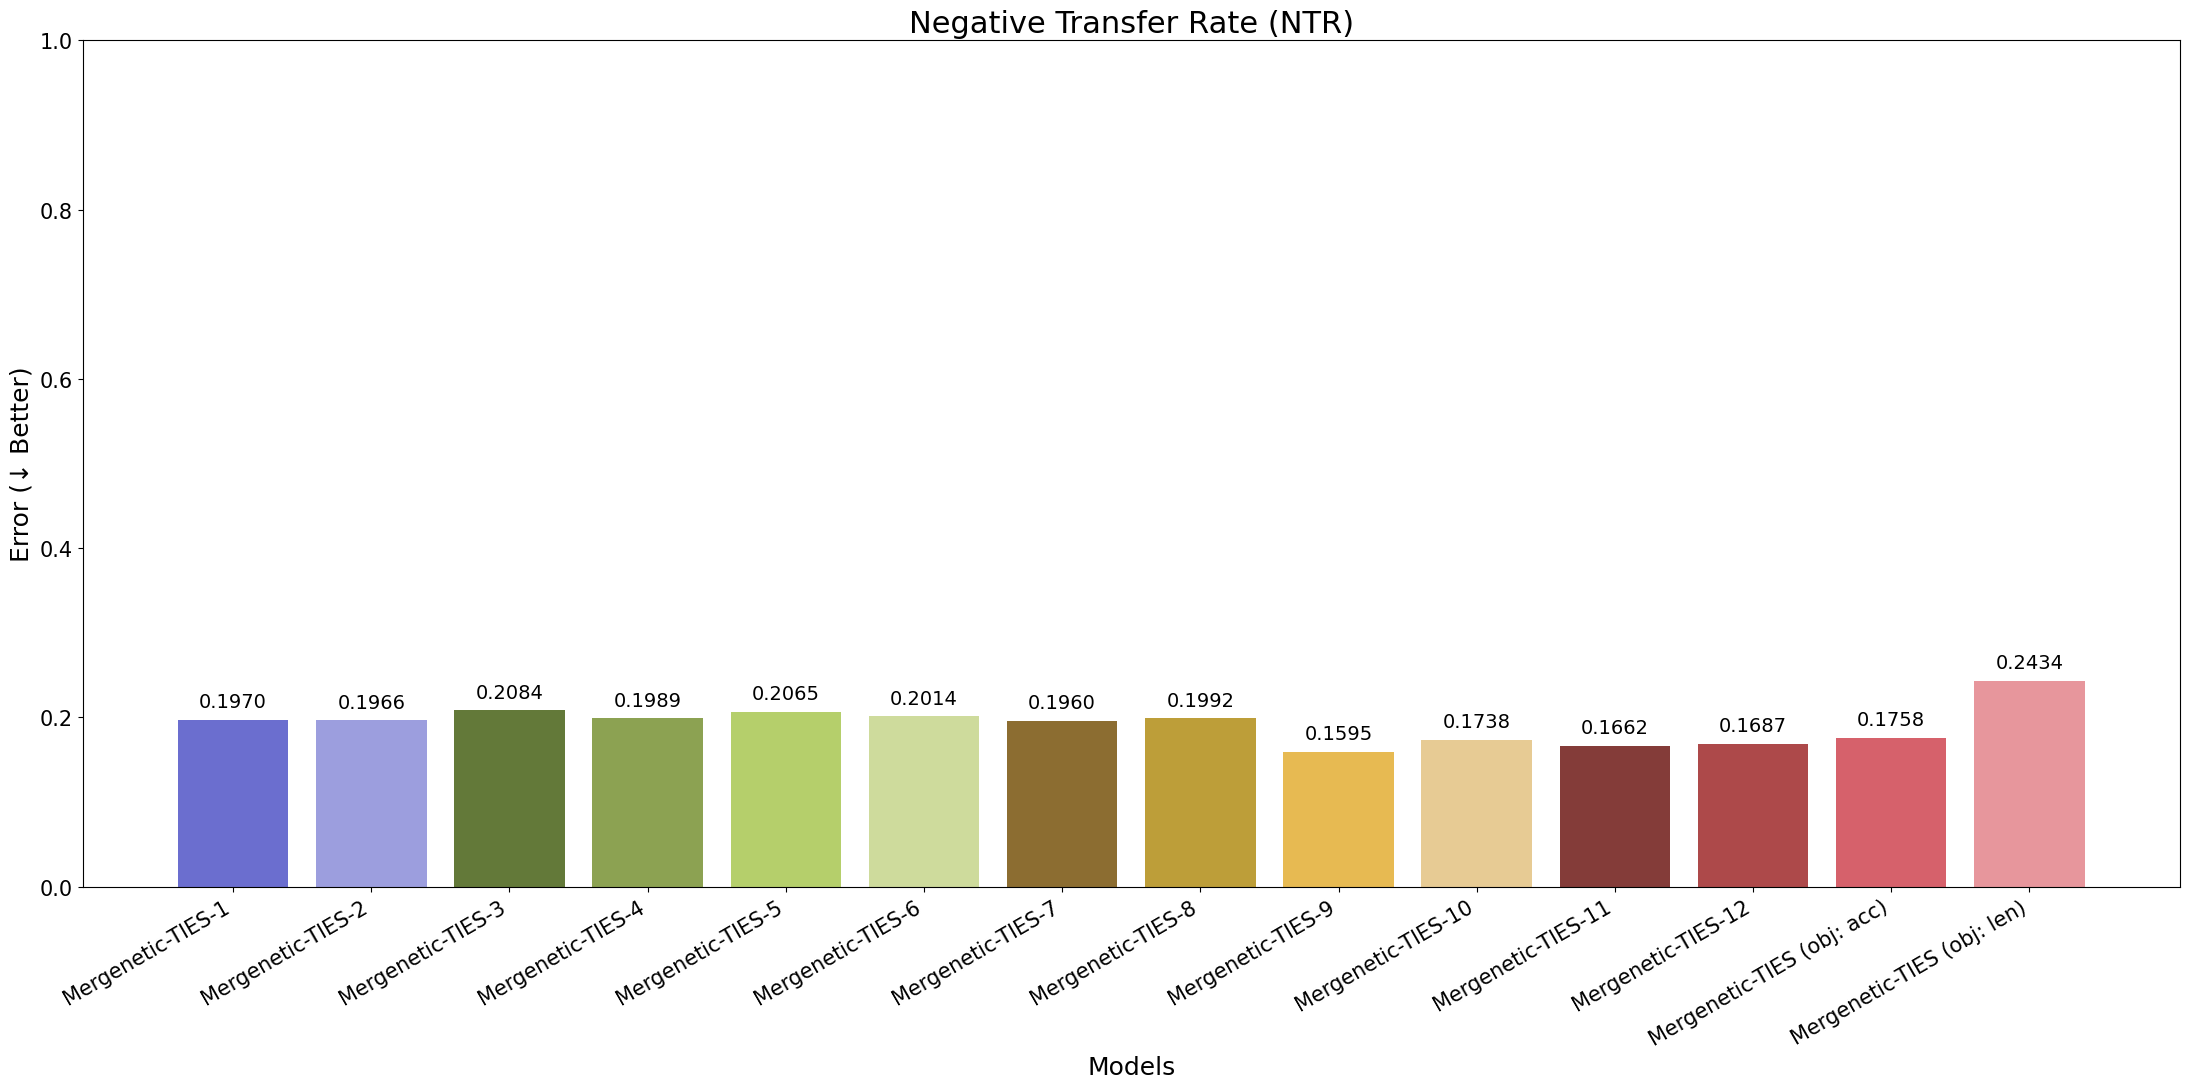

In [20]:
import matplotlib.pyplot as plt

# === Models ===
Mergenetic_TIES_models = [
    "Mergenetic-TIES-1", "Mergenetic-TIES-2", "Mergenetic-TIES-3", "Mergenetic-TIES-4", "Mergenetic-TIES-5",
    "Mergenetic-TIES-6", "Mergenetic-TIES-7", "Mergenetic-TIES-8", "Mergenetic-TIES-9", "Mergenetic-TIES-10",
    "Mergenetic-TIES-11", "Mergenetic-TIES-12", "Mergenetic-TIES (obj: acc)", "Mergenetic-TIES (obj: len)"
]

# === NTR scores ===
Mergenetic_TIES_NTR = [0.1970, 0.1966, 0.2084, 0.1989, 0.2065,
                       0.2014, 0.1960, 0.1992, 0.1595, 0.1738,
                       0.1662, 0.1687, 0.1758, 0.2434]

colors = list(plt.cm.tab20b.colors[2:])

# === Font constants
FONT_TITLE = 22
FONT_AXIS_LABEL = 18
FONT_TICK = 15
FONT_ANNOTATION = 14

# === Plot
plt.figure(figsize=(22, 11))
bars = plt.bar(Mergenetic_TIES_models, Mergenetic_TIES_NTR, color=colors)

# Annotazioni sopra ogni barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f"{Mergenetic_TIES_NTR[i]:.4f}", ha='center', va='bottom', fontsize=FONT_ANNOTATION)

plt.ylabel("Error (↓ Better)", fontsize=FONT_AXIS_LABEL)
plt.xlabel("Models", fontsize=FONT_AXIS_LABEL)
plt.title("Negative Transfer Rate (NTR)", fontsize=FONT_TITLE)
plt.xticks(rotation=30, ha="right", fontsize=FONT_TICK)
plt.yticks(fontsize=FONT_TICK)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()